In [1]:
from ivi import * 
from schemes import * 
from utils import *
from fourier import *

from tqdm import tqdm 
import time

### I. Sample paths of $(\widehat V, \widehat U, \widehat Z)$ 

In [329]:
M = 100
n = 400
T = 0.2
t_grid = np.linspace(0, T, n+1) 
N = np.random.normal(size=(M, n))
eta = np.random.uniform(size=(M, n))

In [331]:
V0, a, b, c = 0.023, 2.15*0.057, -2.15, 0.86

In [333]:
hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N, eta)
hat_V_, hat_U_, hat_Z_ = simulate_hat_VUZ(V0, T, 0.0, b, c, N, eta)

In [334]:
U, Z = get_UZ_trajectories(hat_U, hat_Z) 
U_, Z_ = get_UZ_trajectories(hat_U_, hat_Z_) 

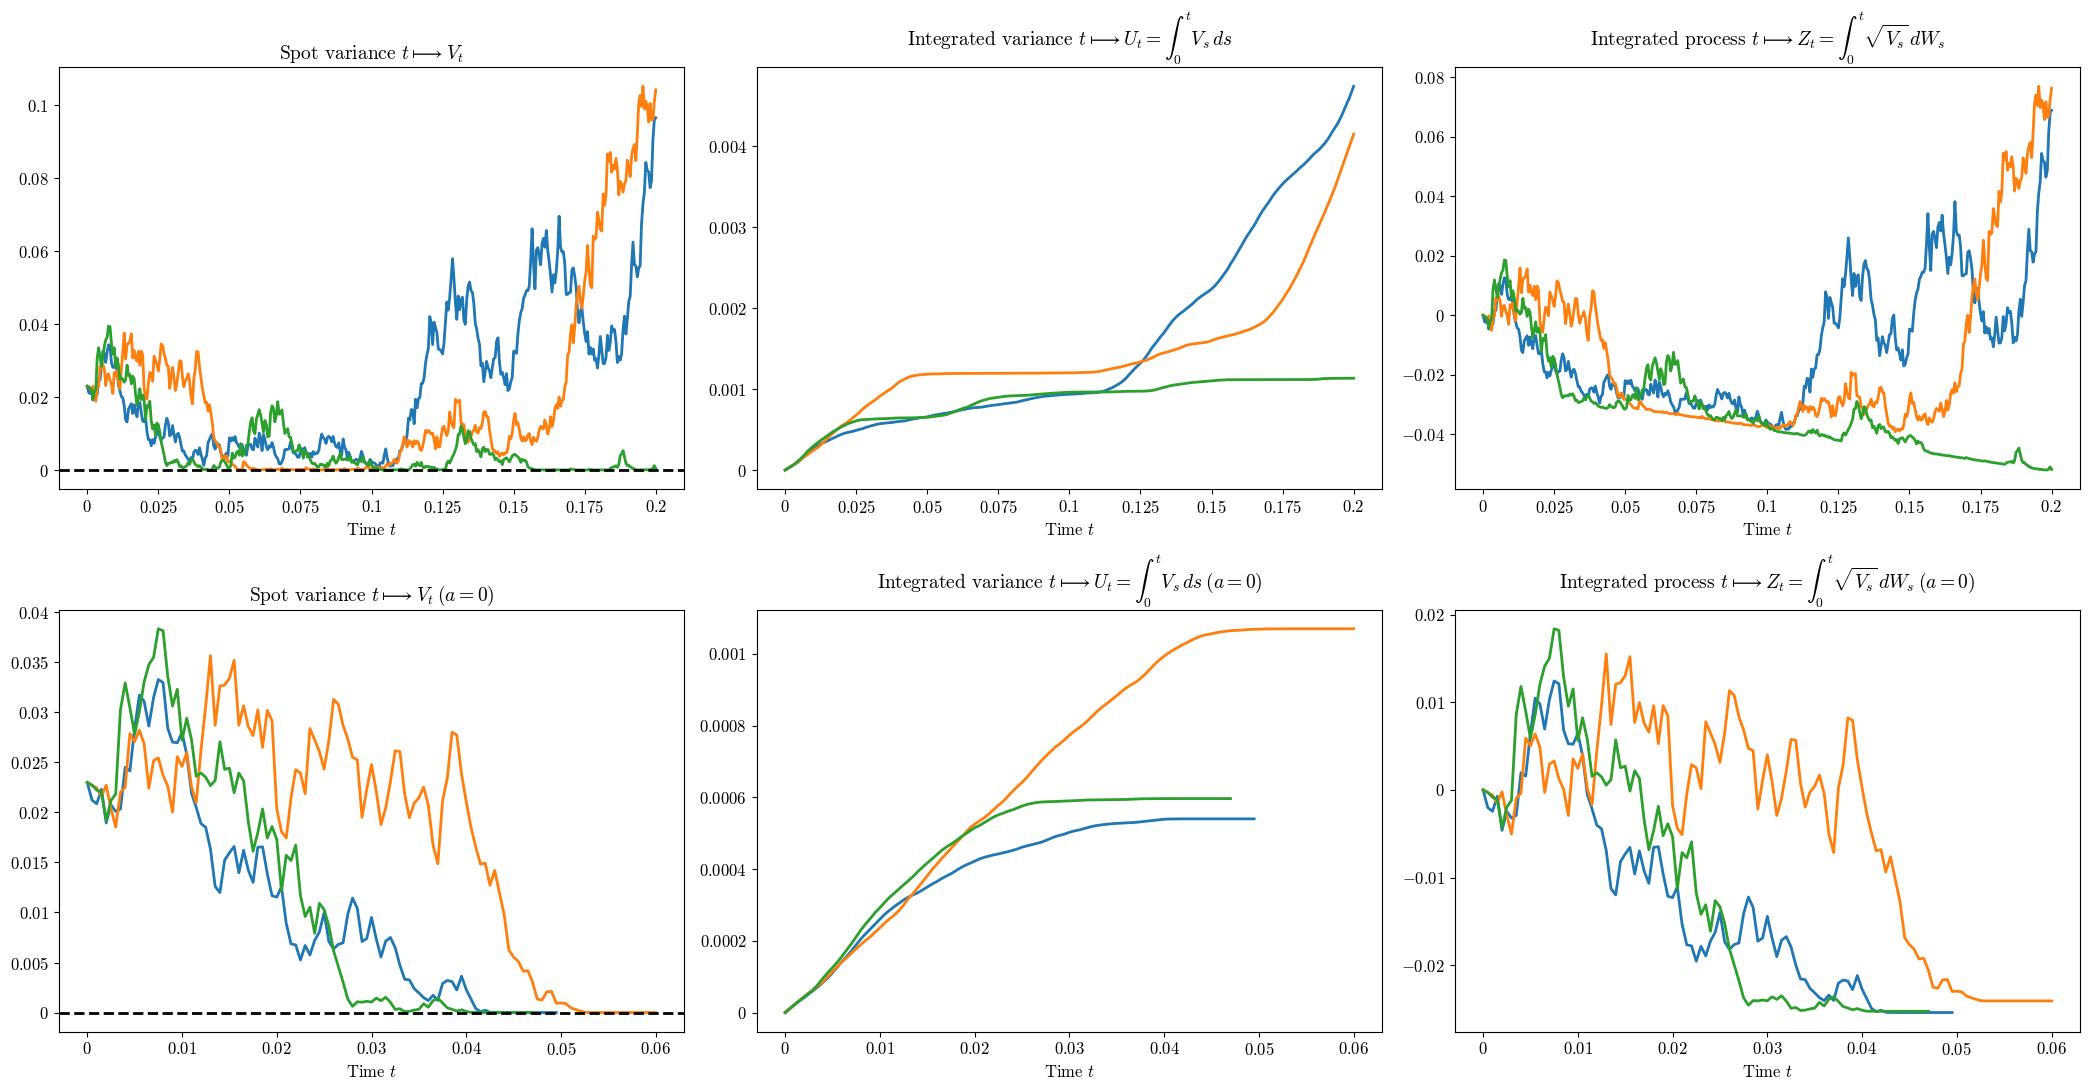

In [337]:
fig, ax = plt.subplots(2, 3, figsize=(21, 11))
ax = ax.flatten() 

for i in range(3) : 
    ax[0].plot(t_grid, hat_V[i,:], lw=2)
    ax[1].plot(t_grid, U[i,:], lw=2)
    ax[2].plot(t_grid, Z[i,:], lw=2)

for i in range(3) : 
    ax[3].plot(t_grid, hat_V_[i,:], lw=2)
    ax[4].plot(t_grid, U_[i,:], lw=2)
    ax[5].plot(t_grid, Z_[i,:], lw=2)

ax[0].set_title(r"$\text{Spot variance }t\longmapsto V_t$", fontsize=14)
ax[1].set_title(r"$\text{Integrated variance }t\longmapsto U_t = \int_0^t V_s\,ds$", fontsize=14)
ax[2].set_title(r"$\text{Integrated process }t\longmapsto Z_t = \int_0^t \sqrt{V_s}\,dW_s$", fontsize=14)

ax[3].set_title(r"$\text{Spot variance }t\longmapsto V_t\: (a=0)$", fontsize=14)
ax[4].set_title(r"$\text{Integrated variance }t\longmapsto U_t = \int_0^t V_s\,ds\: (a=0)$", fontsize=14)
ax[5].set_title(r"$\text{Integrated process }t\longmapsto Z_t = \int_0^t \sqrt{V_s}\,dW_s\: (a=0)$", fontsize=14)

ax[0].axhline(0.0, lw=2, color="black", linestyle="--") 
ax[3].axhline(0.0, lw=2, color="black", linestyle="--") 

for i in range(6) : 
    ax[i].set_xlabel(r"$\text{Time }t$", fontsize=12)
    ax[i].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

### II. Numerical illustrations for the integrated process $U$ 

**$\boldsymbol q$-Volatility swaps.** The payoff of a $q$-Volatility swap is $R_T^q - K^q$, where $R_T^q = \left(\frac 1 T U_T\right)^q$ is the realized $q$-volatility and $K^q$ the $q$-volatility strike. The aim in pricing $q$-volatility swaps is to find the fair strike price, i.e. $K^q = \mathbb{E}[R_T^q]$. We use the following result:
$$\mathbb{E}[X^q] = \frac{q}{\Gamma(1-q)}\int_0^\infty \frac{1-\mathbb{E}[e^{-uX}]}{u^{q+1}}\, du, \quad q\in(0,1),$$
and $X$ a nonnegative random variable. Specifically, the fair strike of the volatility swap ($q=1/2$), is thus of the form 
\begin{align*}
\mathbb{E}\left[\sqrt{\frac{1}{T}U_T}\right] = \frac{1}{2\sqrt{\pi}}\int_0^\infty \frac{1-\widetilde M_0(u)}{u^{3/2}}\, du, \quad \widetilde M_0(u) := \mathbb{E}\left[e^{-\frac{u}{T}U_T}\right].
\end{align*}

Instead using the Gauss-Laguerre quadrature to approximate this integral, we will use the Gauss-Legendre one on $[0, U_\text{max}]$ to avoid the overflow. More precisely, using the fact that $\widetilde M_0(u) \approx 0$ when $u$ is sufficiently large,  
\begin{align*}
\int_0^\infty \frac{1-\widetilde M_0(u)}{u^{q+1}}\, du &\approx \int_0^{U_\text{max}} \frac{1-\widetilde M_0(u)}{u^{q+1}}\, du + \frac{1}{qU^q_\text{max}}
\end{align*} 

In [80]:
n_range = np.linspace(1, 100, 10, dtype=int)
M = 2*int(1e6)

N_values = []
eta_values = [] 
bernoulli_values = [] 

for n in tqdm(n_range) : 
    N_values.append(simulate_antithetic(M, n))
    eta_values.append(np.random.uniform(size=(M, n)))
    bernoulli_values.append(np.random.binomial(n=1, p=0.5, size=(M, n)))
    
T = 1 
S0 = 100

100%|███████████████████████████████████████████| 10/10 [00:31<00:00,  3.11s/it]


#### II.1. Case 1 

In [82]:
V0, a, b, c, rho = 0.006, 17.25 * 0.018, -17.25, 2.95, -0.68

alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)

In [84]:
hat_var_swap_1, hat_vol_swap_1, hat_laplace_1 = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
QE_var_swap_1, QE_vol_swap_1, QE_laplace_1 = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
TG_var_swap_1, TG_vol_swap_1, TG_laplace_1 = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
AL_var_swap_1, AL_vol_swap_1, AL_laplace_1 = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))


for i, n in enumerate(tqdm(n_range)) :
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N_values[i], eta_values[i])
    U_T = np.sum(hat_U, axis=1)
    mean, var, _, _ = monte_carlo(U_T)
    hat_var_swap_1[i] = mean 
    if i == len(n_range)-1 : 
        hat_3_std_var_swap_1 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.sqrt(U_T))
    hat_vol_swap_1[i] = mean 
    if i == len(n_range)-1 : 
        hat_3_std_vol_swap_1 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.exp(-U_T))
    hat_laplace_1[i] = mean 
    if i == len(n_range)-1 : 
        hat_3_std_laplace_1 = 3 * np.sqrt(var/M)

    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i])
    U_T = T/n * (0.5 * V[:, 0] + V[:, 1:-1].sum(axis=1) + 0.5 * V[:, -1])
    mean, var, _, _ = monte_carlo(U_T)
    QE_var_swap_1[i] = mean 
    if i == len(n_range)-1 : 
        QE_3_std_var_swap_1 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.sqrt(U_T))
    QE_vol_swap_1[i] = mean 
    if i == len(n_range)-1 : 
        QE_3_std_vol_swap_1 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.exp(-U_T))
    QE_laplace_1[i] = mean 
    if i == len(n_range)-1 : 
        QE_3_std_laplace_1 = 3 * np.sqrt(var/M)

    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i], alpha, f_mu_values, f_sigma_values)
    U_T = T/n * (0.5 * V[:, 0] + V[:, 1:-1].sum(axis=1) + 0.5 * V[:, -1])
    mean, var, _, _ = monte_carlo(U_T)
    TG_var_swap_1[i] = mean 
    if i == len(n_range)-1 : 
        TG_3_std_var_swap_1 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.sqrt(U_T))
    TG_vol_swap_1[i] = mean 
    if i == len(n_range)-1 : 
        TG_3_std_vol_swap_1 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.exp(-U_T))
    TG_laplace_1[i] = mean 
    if i == len(n_range)-1 : 
        TG_3_std_laplace_1 = 3 * np.sqrt(var/M)

    _, U, _ = simulate_AL(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i], bernoulli_values[i])
    U_T = U[:, -1] 
    mean, var, _, _ = monte_carlo(U_T)
    AL_var_swap_1[i] = mean 
    if i == len(n_range)-1 : 
        AL_3_std_var_swap_1 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.sqrt(U_T))
    AL_vol_swap_1[i] = mean 
    if i == len(n_range)-1 : 
        AL_3_std_vol_swap_1 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.exp(-U_T))
    AL_laplace_1[i] = mean 
    if i == len(n_range)-1 : 
        AL_3_std_laplace_1 = 3 * np.sqrt(var/M)

100%|███████████████████████████████████████████| 10/10 [02:17<00:00, 13.73s/it]


In [86]:
var_swap_1_true = compute_variance_swap(T, V0, a, b, c)
vol_swap_1_true = compute_vol_swap(T, V0, a, b, c, 2000, 10000)
laplace_1_true = compute_Heston_char_func(T, 0.0, -1, V0, a, b, c, rho)
var_swap_1_true, vol_swap_1_true, laplace_1_true

(0.01730434784851608, 0.11593016809933343, 0.9830648376719724)

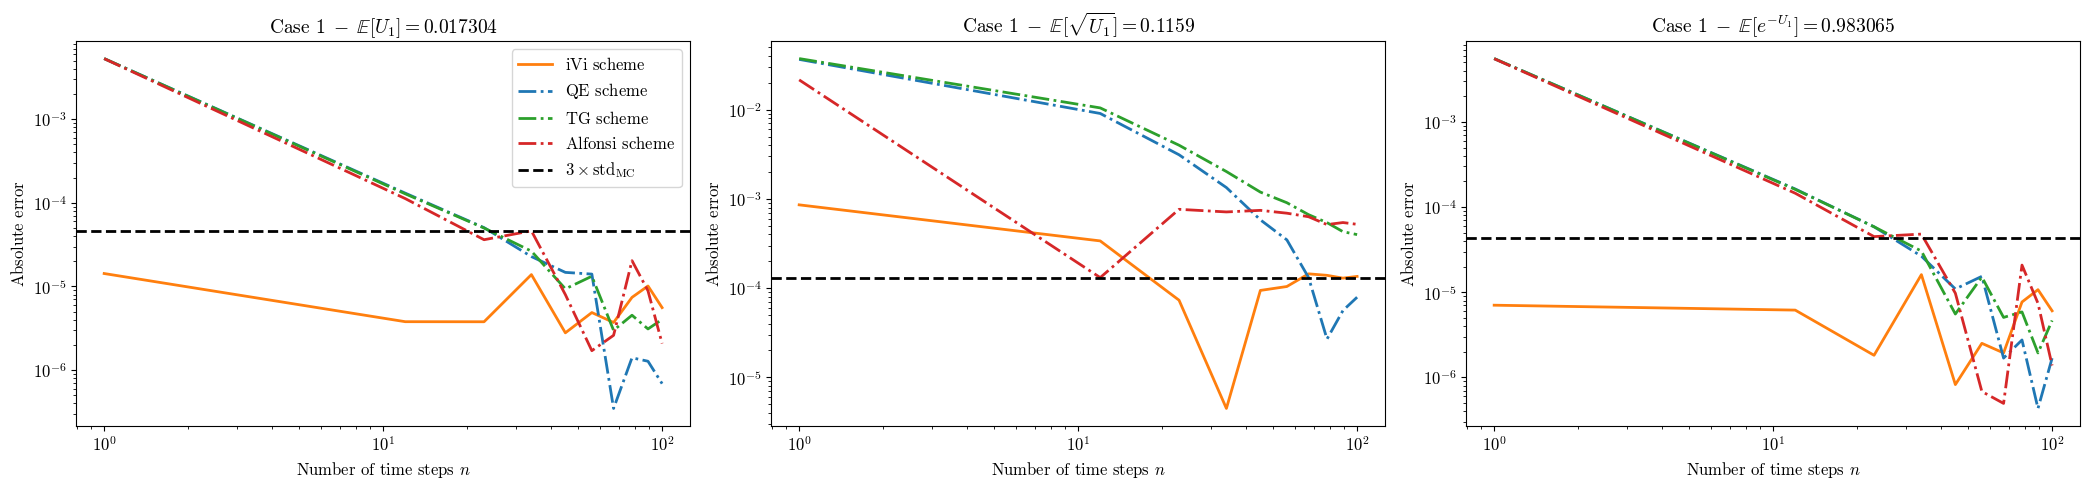

In [97]:
fig, ax = plt.subplots(1, 3, figsize=(21, 5))

ax[0].loglog(n_range, np.abs(var_swap_1_true - hat_var_swap_1), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[0].loglog(n_range, np.abs(var_swap_1_true - QE_var_swap_1), lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE scheme}$")
ax[0].loglog(n_range, np.abs(var_swap_1_true - TG_var_swap_1), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG scheme}$")
ax[0].loglog(n_range, np.abs(var_swap_1_true - AL_var_swap_1), lw=2, linestyle="-.", color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[0].axhline(hat_3_std_var_swap_1, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[0].set_title(r"$\text{Case 1}\;-\;\mathbb{E}[U_{1}] = 0.017304$", fontsize=14)

ax[1].loglog(n_range, np.abs(vol_swap_1_true - hat_vol_swap_1), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[1].loglog(n_range, np.abs(vol_swap_1_true - QE_vol_swap_1), lw=2, linestyle="-.", color="tab:blue", label=r"$\text{QE scheme}$")
ax[1].loglog(n_range, np.abs(vol_swap_1_true - TG_vol_swap_1), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG scheme}$")
ax[1].loglog(n_range, np.abs(vol_swap_1_true - AL_vol_swap_1), lw=2, linestyle="-.", color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[1].axhline(hat_3_std_vol_swap_1, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[1].set_title(r"$\text{Case 1}\;-\;\mathbb{E}[\sqrt{U_{1}}] = 0.1159$", fontsize=14)

ax[2].loglog(n_range, np.abs(laplace_1_true - hat_laplace_1), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[2].loglog(n_range, np.abs(laplace_1_true - QE_laplace_1), lw=2, linestyle="-.", color="tab:blue", label=r"$\text{QE scheme}$")
ax[2].loglog(n_range, np.abs(laplace_1_true - TG_laplace_1), lw=2, linestyle="-.", color="tab:green", label=r"$\text{TG scheme}$")
ax[2].loglog(n_range, np.abs(laplace_1_true - AL_laplace_1), lw=2, linestyle="-.", color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[2].axhline(hat_3_std_laplace_1, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[2].set_title(r"$\text{Case 1}\;-\;\mathbb{E}[e^{-U_{1}}] = 0.983065$", fontsize=14)

for i in range(3) : 
    ax[i].set_ylabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Number of time steps } n$", fontsize=12)
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$"))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"$10^{{{int(np.log10(y))}}}$"))
    ax[i].tick_params(axis='both', labelsize=12)

ax[0].legend(fontsize=12)

plt.tight_layout()
plt.show()

#### II.2. Case 2

In [101]:
V0, a, b, c, rho = 0.023, 2.15*0.057, -2.15, 0.86, -0.70 

alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)

In [103]:
hat_var_swap_2, hat_vol_swap_2, hat_laplace_2 = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
QE_var_swap_2, QE_vol_swap_2, QE_laplace_2 = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
TG_var_swap_2, TG_vol_swap_2, TG_laplace_2 = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
AL_var_swap_2, AL_vol_swap_2, AL_laplace_2 = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))


for i, n in enumerate(tqdm(n_range)) :
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N_values[i], eta_values[i])
    U_T = np.sum(hat_U, axis=1)
    mean, var, _, _ = monte_carlo(U_T)
    hat_var_swap_2[i] = mean 
    if i == len(n_range)-1 : 
        hat_3_std_var_swap_2 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.sqrt(U_T))
    hat_vol_swap_2[i] = mean 
    if i == len(n_range)-1 : 
        hat_3_std_vol_swap_2 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.exp(-U_T))
    hat_laplace_2[i] = mean 
    if i == len(n_range)-1 : 
        hat_3_std_laplace_2 = 3 * np.sqrt(var/M)

    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i])
    U_T = T/n * (0.5 * V[:, 0] + V[:, 1:-1].sum(axis=1) + 0.5 * V[:, -1])
    mean, var, _, _ = monte_carlo(U_T)
    QE_var_swap_2[i] = mean 
    if i == len(n_range)-1 : 
        QE_3_std_var_swap_2 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.sqrt(U_T))
    QE_vol_swap_2[i] = mean 
    if i == len(n_range)-1 : 
        QE_3_std_vol_swap_2 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.exp(-U_T))
    QE_laplace_2[i] = mean 
    if i == len(n_range)-1 : 
        QE_3_std_laplace_2 = 3 * np.sqrt(var/M)

    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i], alpha, f_mu_values, f_sigma_values)
    U_T = T/n * (0.5 * V[:, 0] + V[:, 1:-1].sum(axis=1) + 0.5 * V[:, -1])
    mean, var, _, _ = monte_carlo(U_T)
    TG_var_swap_2[i] = mean 
    if i == len(n_range)-1 : 
        TG_3_std_var_swap_2 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.sqrt(U_T))
    TG_vol_swap_2[i] = mean 
    if i == len(n_range)-1 : 
        TG_3_std_vol_swap_2 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.exp(-U_T))
    TG_laplace_2[i] = mean 
    if i == len(n_range)-1 : 
        TG_3_std_laplace_2 = 3 * np.sqrt(var/M)

    _, U, _ = simulate_AL(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i], bernoulli_values[i])
    U_T = U[:, -1] 
    mean, var, _, _ = monte_carlo(U_T)
    AL_var_swap_2[i] = mean 
    if i == len(n_range)-1 : 
        AL_3_std_var_swap_2 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.sqrt(U_T))
    AL_vol_swap_2[i] = mean 
    if i == len(n_range)-1 : 
        AL_3_std_vol_swap_2 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.exp(-U_T))
    AL_laplace_2[i] = mean 
    if i == len(n_range)-1 : 
        AL_3_std_laplace_2 = 3 * np.sqrt(var/M)

100%|███████████████████████████████████████████| 10/10 [02:53<00:00, 17.38s/it]


In [123]:
var_swap_2_true = compute_variance_swap(T, V0, a, b, c)
vol_swap_2_true = compute_vol_swap(T, V0, a, b, c, 10000, 10000)
laplace_2_true = compute_Heston_char_func(T, 0.0, -1, V0, a, b, c, rho)
var_swap_2_true, vol_swap_2_true, laplace_2_true

(0.04302812156479019, 0.1840416589423806, 0.9590194384335732)

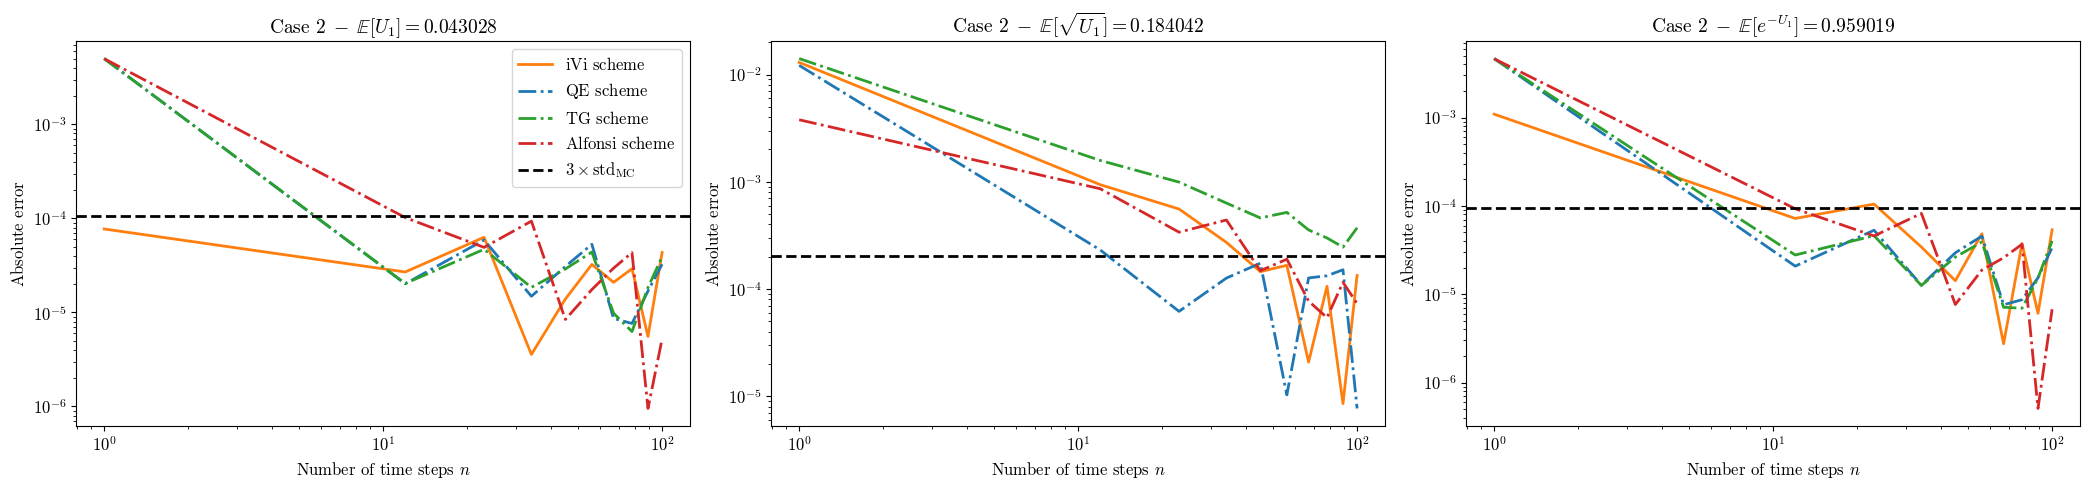

In [165]:
fig, ax = plt.subplots(1, 3, figsize=(21, 5))

ax[0].loglog(n_range, np.abs(var_swap_2_true - hat_var_swap_2), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[0].loglog(n_range, np.abs(var_swap_2_true - QE_var_swap_2), lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE scheme}$")
ax[0].loglog(n_range, np.abs(var_swap_2_true - TG_var_swap_2), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG scheme}$")
ax[0].loglog(n_range, np.abs(var_swap_2_true - AL_var_swap_2), lw=2, linestyle="-.", color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[0].axhline(hat_3_std_var_swap_2, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[0].set_title(r"$\text{Case 2}\;-\;\mathbb{E}[U_{1}] = 0.043028$", fontsize=14)

ax[1].loglog(n_range, np.abs(vol_swap_2_true - hat_vol_swap_2), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[1].loglog(n_range, np.abs(vol_swap_2_true - QE_vol_swap_2), lw=2, linestyle="-.", color="tab:blue", label=r"$\text{QE scheme}$")
ax[1].loglog(n_range, np.abs(vol_swap_2_true - TG_vol_swap_2), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG scheme}$")
ax[1].loglog(n_range, np.abs(vol_swap_2_true - AL_vol_swap_2), lw=2, linestyle="-.", color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[1].axhline(hat_3_std_vol_swap_2, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[1].set_title(r"$\text{Case 2}\;-\;\mathbb{E}[\sqrt{U_{1}}] = 0.184042$", fontsize=14)

ax[2].loglog(n_range, np.abs(laplace_2_true - hat_laplace_2), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[2].loglog(n_range, np.abs(laplace_2_true - QE_laplace_2), lw=2, linestyle="-.", color="tab:blue", label=r"$\text{QE scheme}$")
ax[2].loglog(n_range, np.abs(laplace_2_true - TG_laplace_2), lw=2, linestyle="-.", color="tab:green", label=r"$\text{TG scheme}$")
ax[2].loglog(n_range, np.abs(laplace_2_true - AL_laplace_2), lw=2, linestyle="-.", color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[2].axhline(hat_3_std_laplace_2, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[2].set_title(r"$\text{Case 2}\;-\;\mathbb{E}[e^{-U_{1}}] = 0.959019$", fontsize=14)

for i in range(3) : 
    ax[i].set_ylabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Number of time steps } n$", fontsize=12)
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$"))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"$10^{{{int(np.log10(y))}}}$"))
    ax[i].tick_params(axis='both', labelsize=12)

ax[0].legend(fontsize=12)

plt.tight_layout()
plt.show()

#### II.3. Case 3

In [139]:
V0, a, b, c, rho = 0.04, 0.5*0.04, -0.5, 1.0, -0.9

alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)

In [141]:
hat_var_swap_3, hat_vol_swap_3, hat_laplace_3 = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
QE_var_swap_3, QE_vol_swap_3, QE_laplace_3 = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
TG_var_swap_3, TG_vol_swap_3, TG_laplace_3 = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
AL_var_swap_3, AL_vol_swap_3, AL_laplace_3 = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))


for i, n in enumerate(tqdm(n_range)) :
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N_values[i], eta_values[i])
    U_T = np.sum(hat_U, axis=1)
    mean, var, _, _ = monte_carlo(U_T)
    hat_var_swap_3[i] = mean 
    if i == len(n_range)-1 : 
        hat_3_std_var_swap_3 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.sqrt(U_T))
    hat_vol_swap_3[i] = mean 
    if i == len(n_range)-1 : 
        hat_3_std_vol_swap_3 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.exp(-U_T))
    hat_laplace_3[i] = mean 
    if i == len(n_range)-1 : 
        hat_3_std_laplace_3 = 3 * np.sqrt(var/M)

    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i])
    U_T = T/n * (0.5 * V[:, 0] + V[:, 1:-1].sum(axis=1) + 0.5 * V[:, -1])
    mean, var, _, _ = monte_carlo(U_T)
    QE_var_swap_3[i] = mean 
    if i == len(n_range)-1 : 
        QE_3_std_var_swap_3 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.sqrt(U_T))
    QE_vol_swap_3[i] = mean 
    if i == len(n_range)-1 : 
        QE_3_std_vol_swap_3 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.exp(-U_T))
    QE_laplace_3[i] = mean 
    if i == len(n_range)-1 : 
        QE_3_std_laplace_3 = 3 * np.sqrt(var/M)

    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i], alpha, f_mu_values, f_sigma_values)
    U_T = T/n * (0.5 * V[:, 0] + V[:, 1:-1].sum(axis=1) + 0.5 * V[:, -1])
    mean, var, _, _ = monte_carlo(U_T)
    TG_var_swap_3[i] = mean 
    if i == len(n_range)-1 : 
        TG_3_std_var_swap_3 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.sqrt(U_T))
    TG_vol_swap_3[i] = mean 
    if i == len(n_range)-1 : 
        TG_3_std_vol_swap_3 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.exp(-U_T))
    TG_laplace_3[i] = mean 
    if i == len(n_range)-1 : 
        TG_3_std_laplace_3 = 3 * np.sqrt(var/M)

    _, U, _ = simulate_AL(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i], bernoulli_values[i])
    U_T = U[:, -1] 
    mean, var, _, _ = monte_carlo(U_T)
    AL_var_swap_3[i] = mean 
    if i == len(n_range)-1 : 
        AL_3_std_var_swap_3 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.sqrt(U_T))
    AL_vol_swap_3[i] = mean 
    if i == len(n_range)-1 : 
        AL_3_std_vol_swap_3 = 3 * np.sqrt(var/M)
    mean, var, _, _ = monte_carlo(np.exp(-U_T))
    AL_laplace_3[i] = mean 
    if i == len(n_range)-1 : 
        AL_3_std_laplace_3 = 3 * np.sqrt(var/M)

100%|███████████████████████████████████████████| 10/10 [03:01<00:00, 18.15s/it]


In [143]:
var_swap_3_true = compute_variance_swap(T, V0, a, b, c)
vol_swap_3_true = compute_vol_swap(T, V0, a, b, c, 10000, 10000)
laplace_3_true = compute_Heston_char_func(T, 0.0, -1, V0, a, b, c, rho)
var_swap_3_true, vol_swap_3_true, laplace_3_true

(0.04000000000000001, 0.13838089806653392, 0.964671116080271)

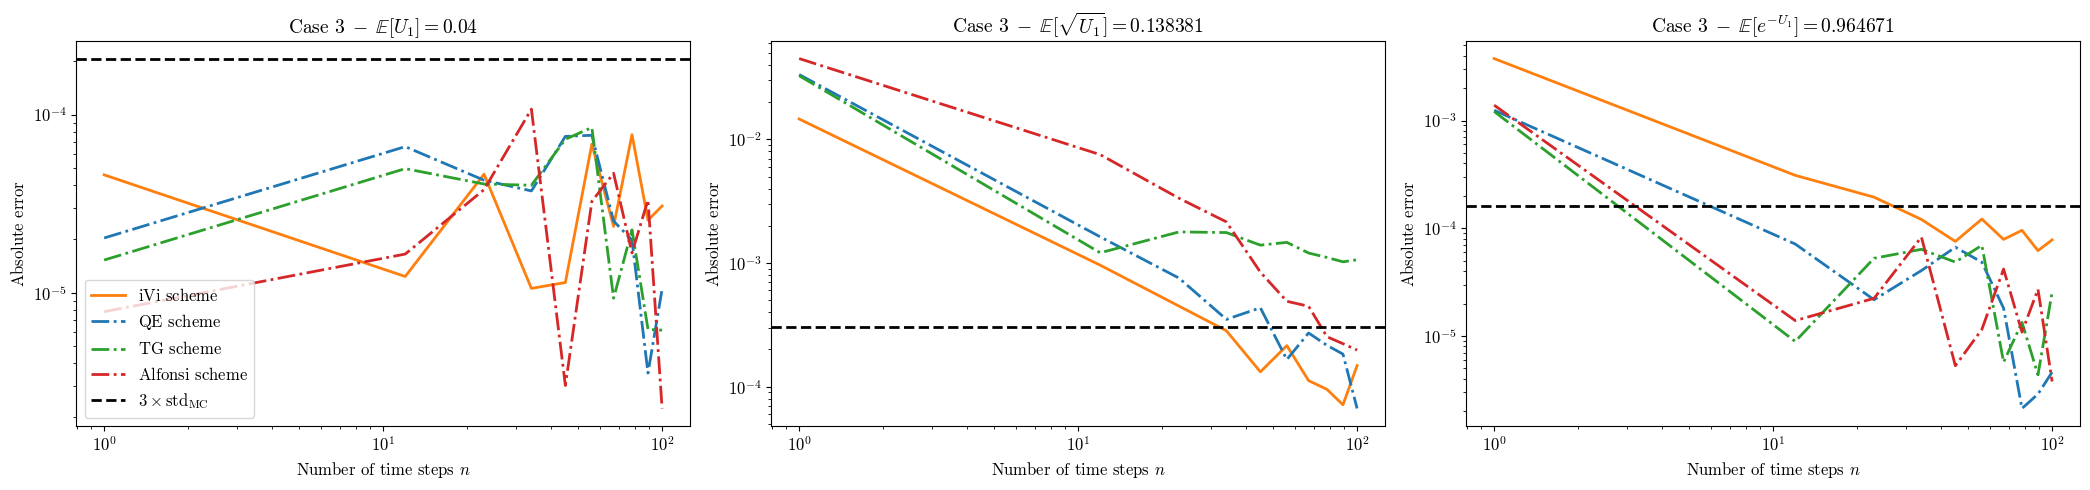

In [157]:
fig, ax = plt.subplots(1, 3, figsize=(21, 5))

ax[0].loglog(n_range, np.abs(var_swap_3_true - hat_var_swap_3), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[0].loglog(n_range, np.abs(var_swap_3_true - QE_var_swap_3), lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE scheme}$")
ax[0].loglog(n_range, np.abs(var_swap_3_true - TG_var_swap_3), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG scheme}$")
ax[0].loglog(n_range, np.abs(var_swap_3_true - AL_var_swap_3), lw=2, linestyle="-.", color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[0].axhline(hat_3_std_var_swap_3, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[0].set_title(r"$\text{Case 3}\;-\;\mathbb{E}[U_{1}] = 0.04$", fontsize=14)

ax[1].loglog(n_range, np.abs(vol_swap_3_true - hat_vol_swap_3), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[1].loglog(n_range, np.abs(vol_swap_3_true - QE_vol_swap_3), lw=2, linestyle="-.", color="tab:blue", label=r"$\text{QE scheme}$")
ax[1].loglog(n_range, np.abs(vol_swap_3_true - TG_vol_swap_3), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG scheme}$")
ax[1].loglog(n_range, np.abs(vol_swap_3_true - AL_vol_swap_3), lw=2, linestyle="-.", color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[1].axhline(hat_3_std_vol_swap_3, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[1].set_title(r"$\text{Case 3}\;-\;\mathbb{E}[\sqrt{U_{1}}] = 0.138381$", fontsize=14)

ax[2].loglog(n_range, np.abs(laplace_3_true - hat_laplace_3), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[2].loglog(n_range, np.abs(laplace_3_true - QE_laplace_3), lw=2, linestyle="-.", color="tab:blue", label=r"$\text{QE scheme}$")
ax[2].loglog(n_range, np.abs(laplace_3_true - TG_laplace_3), lw=2, linestyle="-.", color="tab:green", label=r"$\text{TG scheme}$")
ax[2].loglog(n_range, np.abs(laplace_3_true - AL_laplace_3), lw=2, linestyle="-.", color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[2].axhline(hat_3_std_laplace_3, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[2].set_title(r"$\text{Case 3}\;-\;\mathbb{E}[e^{-U_{1}}] = 0.964671$", fontsize=14)

for i in range(3) : 
    ax[i].set_ylabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Number of time steps } n$", fontsize=12)
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$"))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"$10^{{{int(np.log10(y))}}}$"))
    ax[i].tick_params(axis='both', labelsize=12)

ax[0].legend(loc="lower left", fontsize=12)

plt.tight_layout()
plt.show()

### III. Cumulative distribution of $V_T|V_0$

\begin{align*}
    \mathbb P\big( V_t \leq x |V_s \big) &= F_{\widetilde \chi^2(d, V_sn(s,t))}\left(\dfrac{x\times n(s,t)}{e^{b(t-s)}}\right), \quad d:=\frac{4a}{c^2}, \quad n(s,t) := \frac{4be^{b(t-s)}}{c^2(e^{b(t-s)}-1)}
\end{align*}

In [298]:
def ecdf_on_grid_continuous(samples, grid):
    x = np.sort(np.asarray(samples).ravel())
    return np.searchsorted(x, grid, side="right") / x.size

In [764]:
V0, a, b, c, rho = 0.01, 0.5*0.04, -0.5, 1.0, -0.9 
T = 0.1 
alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)
grid = np.linspace(0, 0.12, 100)

M = 500000
n = 252 

N = simulate_antithetic(M, n)
eta = np.random.uniform(size=(M, n))
B = np.random.binomial(n=1, p=0.5, size=(M, n))

V_iVi, _, _ = simulate_hat_VUZ(V0, T, a, b, c, N, eta)
F_iVi = ecdf_on_grid_continuous(V_iVi[:, -1], grid)

_, V_QE = simulate_QE_M(T, S0, V0, a, b, c, rho, N, eta)
F_QE = ecdf_on_grid_continuous(V_QE[:, -1], grid)

_, V_TG = simulate_TG_M(T, S0, V0, a, b, c, rho, N, eta, alpha, f_mu_values, f_sigma_values)
F_TG = ecdf_on_grid_continuous(V_TG[:, -1], grid)

_, _, V_AL = simulate_AL(T, S0, V0, a, b, c, rho, N, eta, B)
F_AL = ecdf_on_grid_continuous(V_AL[:, -1], grid)

In [766]:
from scipy.stats import ncx2

term1 = 4*b*np.exp(b*T) / (c**2 * (np.exp(b*T)-1))
d = 4*a/c**2 
F_true = ncx2.cdf(grid * term1 / np.exp(b*T), df=d, nc=V0 * term1)

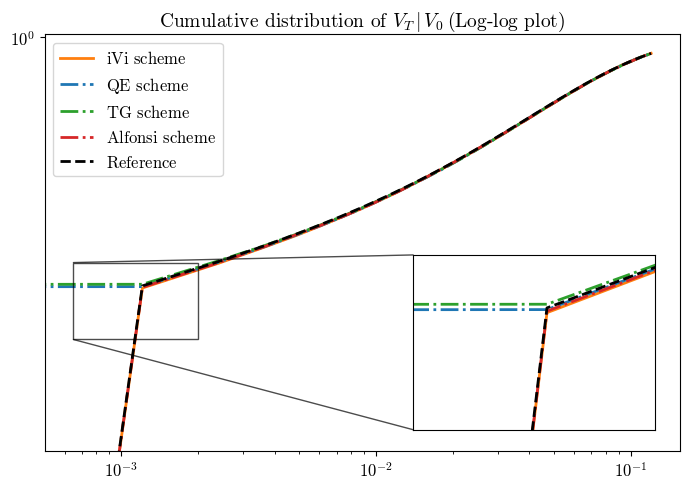

In [810]:
fig, ax = plt.subplots(figsize=(7,5))

x1, x2 = 6.5e-4, 2e-3
y1, y2 = 6.8e-1, 7.5e-1

ax.loglog(grid, F_iVi, lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax.loglog(grid, F_QE,  linestyle="-.", lw=2, color="tab:blue", label=r"$\text{QE scheme}$")
ax.loglog(grid, F_TG,  linestyle="-.", lw=2, color="tab:green", label=r"$\text{TG scheme}$")
ax.loglog(grid, F_AL,  linestyle="-.", lw=2, color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax.loglog(grid, F_true, linestyle="--", lw=2, color="black", label=r"$\text{Reference}$")

ax.legend(loc="upper left", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"$10^{{{int(np.log10(y))}}}$"))
ax.set_yticks([], minor=True)
ax.tick_params(axis='both', labelsize=12)

axins = ax.inset_axes([0.58, 0.05, 0.38, 0.42])
axins.loglog(grid, F_iVi, lw=2, color="tab:orange")
axins.loglog(grid, F_QE,  linestyle="-.", lw=2, color="tab:blue")
axins.loglog(grid, F_TG,  linestyle="-.", lw=2, color="tab:green")
axins.loglog(grid, F_AL,  linestyle="-.", lw=2, color="tab:red")
axins.loglog(grid, F_true, linestyle="--", lw=2, color="black")

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
axins.set_xticks([], minor=False)
axins.set_xticks([], minor=True)
axins.set_yticks([], minor=False)
axins.set_yticks([], minor=True)

ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.7)
ax.set_title(r"$\text{Cumulative distribution of }V_T\,|\,V_0 \:(\text{Log-log plot)}$", fontsize=14)
plt.tight_layout()
plt.show()

### IV. Numerical illustration for the Heston model 

#### IV.1. Option pricing 

<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);"> 
    <strong>Characteristic function.</strong>  Let $u, w \in \mathbb C$ such that $\Re(w) + \frac 12 ((\Re(u)^2 - \Re(u))\leq 0$. 
    $$\phi_0(u,w) := \mathbb{E}\left[\left.e^{u\ln \frac{S_T}{S_0} + w U_T}\right|\mathscr F_0\right] = e^{\phi(T) + \psi(T)V_0},$$ 
    where \begin{align*}
    &\psi(t) = \dfrac{\beta(u)-D(u,w)}{c^2}\frac{1 - e^{-D(u,w)t}}{1 - G(u,w)e^{-D(u,w)t}},\\
    &\phi(t) = \frac{a}{c^2}\left((\beta(u)-D(u,w))t - 2\ln \left(\frac{G(u,w)e^{-D(u,w)t}-1}{G(u,w)-1}\right)\right), \quad t\geq0, \\
    &\beta(u) = -b-u\rho c, \quad D(u,w) = \sqrt{\beta(u)^2 + c^2(-2w+u-u^2)}, \quad G(u,w) = \frac{\beta(u) - D(u,w)}{\beta(u) + D(u,w)}.
    \end{align*} 
</div>

<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);"> 
    <strong>Lewis formula.</strong> Let us consider a European call option on $S$ with maturity $T$ and strike $K$. Its price at time $0$ is given by $C_0(S_0, T, K) = \mathbb{E}[(S_T-K)^+|\mathscr F_0]$. From Lewis, one can price this option using the Fourier inversion formula
    $$C_0(S_0, T, K) = S_0 - \frac K\pi\int_0^\infty \Re\left[e^{i(u-\frac i2)k_0}\phi_0\left(i\left(u-\frac i2\right), 0\right)\right]\dfrac{du}{u^2+\frac 14}, \quad k_0 := \ln\frac{S_0}{K}.$$
</div>

In [52]:
n_range = np.linspace(1, 100, 10, dtype=int)
M = 1*int(1e6)

N_values = []
eta_values = [] 
bernoulli_values = [] 

for n in tqdm(n_range) : 
    N_values.append(simulate_antithetic_d(M, n, 2))
    eta_values.append(np.random.uniform(size=(M, n)))
    bernoulli_values.append(np.random.binomial(n=1, p=0.5, size=(M, n)))

100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.16s/it]


##### Case 1 

In [54]:
V0, a, b, c, rho, T = 0.006, 17.25*0.018, -17.25, 2.95, -0.68, 1
S0 = 100

alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)

In [56]:
hat_price_1_ITM, naive_price_1_ITM, QE_price_1_ITM, TG_price_1_ITM, AL_price_1_ITM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
hat_price_1_ATM, naive_price_1_ATM, QE_price_1_ATM, TG_price_1_ATM, AL_price_1_ATM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
hat_price_1_OTM, naive_price_1_OTM, QE_price_1_OTM, TG_price_1_OTM, AL_price_1_OTM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))

hat_time_1_ITM, naive_time_1_ITM, QE_time_1_ITM, TG_time_1_ITM, AL_time_1_ITM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
hat_time_1_ATM, naive_time_1_ATM, QE_time_1_ATM, TG_time_1_ATM, AL_time_1_ATM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
hat_time_1_OTM, naive_time_1_OTM, QE_time_1_OTM, TG_time_1_OTM, AL_time_1_OTM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))

for i, n in enumerate(tqdm(n_range)) :
    start = time.time()
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N_values[i][:, :, 0], eta_values[i])
    hat_S = simulate_hat_S(hat_U, hat_Z, S0, rho, N_values[i][:, :, 1])
    common_hat = time.time() - start 

    start = time.time()
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 100, 0.0))
    hat_price_1_ATM[i] = mean
    hat_time_1_ATM[i] = common_hat + time.time() - start 
    if i == len(n_range)-1 : 
        hat_3_std_price_1_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 60, 0.0))
    hat_price_1_ITM[i] = mean
    hat_time_1_ITM[i] = common_hat + time.time() - start 
    if i == len(n_range)-1 : 
        hat_3_std_price_1_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 140, 0.0))
    hat_price_1_OTM[i] = mean
    hat_time_1_OTM[i] = common_hat + time.time() - start 
    if i == len(n_range)-1 : 
        hat_3_std_price_1_OTM = 3 * np.sqrt(var/M)

    start = time.time() 
    S, V = simulate_full_truncation(T, S0, V0, a, b, c, rho, N_values[i])
    common_naive = time.time() - start 

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    naive_price_1_ATM[i] = mean
    naive_time_1_ATM[i] = common_naive + time.time() - start 
    if i == len(n_range)-1 : 
        hat_3_std_price_1_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    naive_price_1_ITM[i] = mean
    naive_time_1_ITM[i] = common_naive + time.time() - start 
    if i == len(n_range)-1 : 
        naive_3_std_price_1_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    naive_price_1_OTM[i] = mean
    naive_time_1_OTM[i] = common_naive + time.time() - start 
    if i == len(n_range)-1 :
        naive_3_std_price_1_OTM = 3 * np.sqrt(var/M)

    start = time.time() 
    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i])
    common_QE = time.time() - start 

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    QE_price_1_ATM[i] = mean
    QE_time_1_ATM[i] = common_QE + time.time() - start 
    if i == len(n_range)-1 : 
        QE_3_std_price_1_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    QE_price_1_ITM[i] = mean
    QE_time_1_ITM[i] = common_QE + time.time() - start 
    if i == len(n_range)-1 : 
        QE_3_std_price_1_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    QE_price_1_OTM[i] = mean
    QE_time_1_OTM[i] = common_QE + time.time() - start 
    if i == len(n_range)-1 :
        QE_3_std_price_1_OTM = 3 * np.sqrt(var/M)

    start = time.time() 
    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], alpha, f_mu_values, f_sigma_values)
    common_TG = time.time() - start 
    
    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    TG_price_1_ATM[i] = mean
    TG_time_1_ATM[i] = common_TG + time.time() - start 
    if i == len(n_range)-1 : 
        TG_3_std_price_1_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    TG_price_1_ITM[i] = mean
    TG_time_1_ITM[i] = common_TG + time.time() - start 
    if i == len(n_range)-1 : 
        TG_3_std_price_1_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    TG_price_1_OTM[i] = mean
    TG_time_1_OTM[i] = common_TG + time.time() - start 
    if i == len(n_range)-1 :
        TG_3_std_price_1_OTM = 3 * np.sqrt(var/M)

    start = time.time()
    S, _, V = simulate_AL(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], bernoulli_values[i])
    common_AL = time.time() - start 

    start = time.time()
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    AL_price_1_ATM[i] = mean
    AL_time_1_ATM[i] = common_AL + time.time() - start 
    if i == len(n_range)-1 : 
        AL_3_std_price_1_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    AL_price_1_ITM[i] = mean
    AL_time_1_ITM[i] = common_AL + time.time() - start 
    if i == len(n_range)-1 : 
        AL_3_std_price_1_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    AL_price_1_OTM[i] = mean
    AL_time_1_OTM[i] = common_AL + time.time() - start 
    if i == len(n_range)-1 : 
        AL_3_std_price_1_OTM = 3 * np.sqrt(var/M)

100%|███████████████████████████████████████████| 10/10 [01:00<00:00,  6.05s/it]


In [58]:
true_price_1_ITM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 60, 150, flag="call")
true_price_1_ATM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 100, 150, flag="call")
true_price_1_OTM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 140, 150, flag="call")
true_price_1_ITM, true_price_1_ATM, true_price_1_OTM

(40.1162938845335, 4.345385427983771, 0.0014843170361160674)

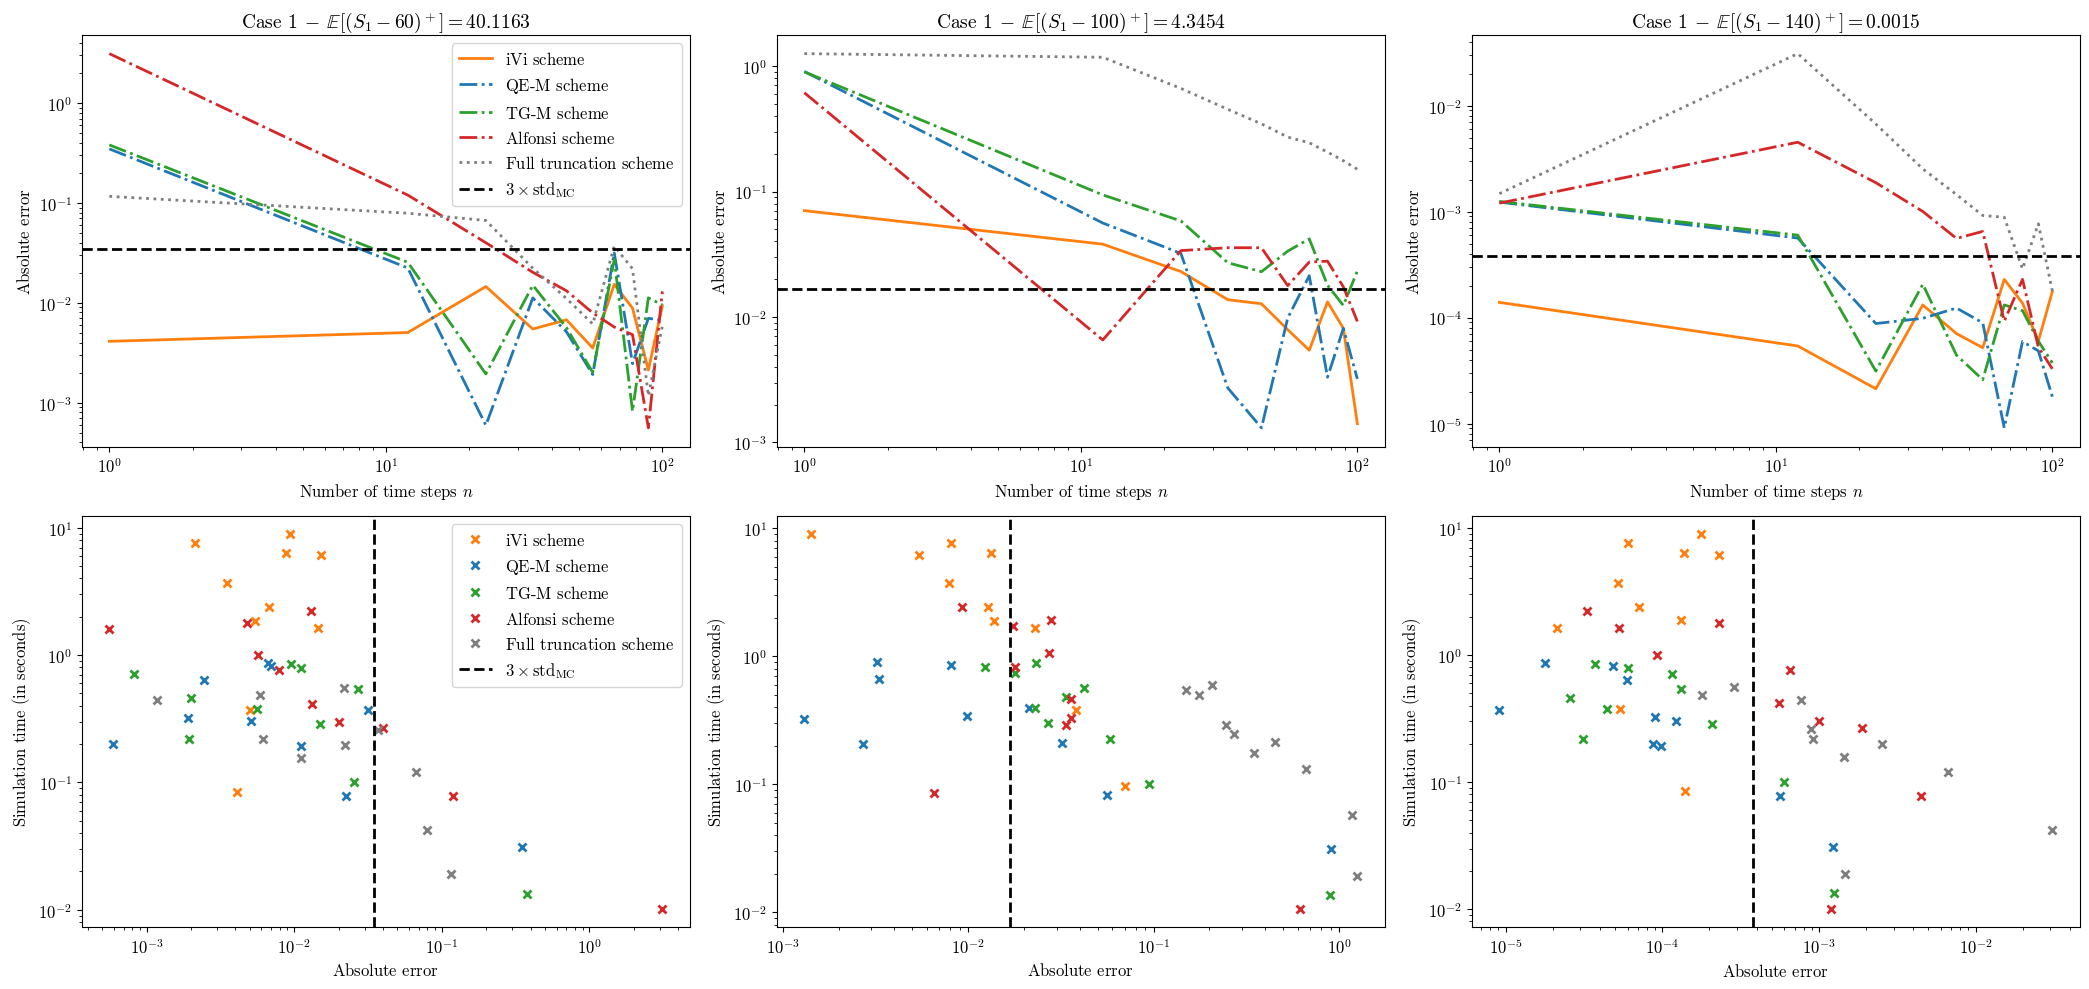

In [71]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
ax = ax.flatten()

ax[0].loglog(n_range, np.abs(true_price_1_ITM - hat_price_1_ITM), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[0].loglog(n_range, np.abs(true_price_1_ITM - QE_price_1_ITM), lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[0].loglog(n_range, np.abs(true_price_1_ITM - TG_price_1_ITM), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[0].loglog(n_range, np.abs(true_price_1_ITM - AL_price_1_ITM), lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[0].loglog(n_range, np.abs(true_price_1_ITM - naive_price_1_ITM), lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[0].axhline(hat_3_std_price_1_ITM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[0].set_title(r"$\text{Case 1}\:-\:\mathbb{E}[(S_1-60)^+] = 40.1163$", fontsize=14)

ax[1].loglog(n_range, np.abs(true_price_1_ATM - hat_price_1_ATM), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[1].loglog(n_range, np.abs(true_price_1_ATM - QE_price_1_ATM), lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[1].loglog(n_range, np.abs(true_price_1_ATM - TG_price_1_ATM), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[1].loglog(n_range, np.abs(true_price_1_ATM - AL_price_1_ATM), lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[1].loglog(n_range, np.abs(true_price_1_ATM - naive_price_1_ATM), lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[1].axhline(hat_3_std_price_1_ATM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[1].set_title(r"$\text{Case 1}\:-\:\mathbb{E}[(S_1-100)^+] = 4.3454$", fontsize=14)

ax[2].loglog(n_range, np.abs(true_price_1_OTM - hat_price_1_OTM), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[2].loglog(n_range, np.abs(true_price_1_OTM - QE_price_1_OTM), lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[2].loglog(n_range, np.abs(true_price_1_OTM - TG_price_1_OTM), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[2].loglog(n_range, np.abs(true_price_1_OTM - AL_price_1_OTM), lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[2].loglog(n_range, np.abs(true_price_1_OTM - naive_price_1_OTM), lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[2].axhline(hat_3_std_price_1_OTM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[2].set_title(r"$\text{Case 1}\:-\:\mathbb{E}[(S_1-140)^+] = 0.0015$", fontsize=14)

ax[3].loglog(np.abs(true_price_1_ITM - hat_price_1_ITM)[::-1], hat_time_1_ITM[::-1], "x", markeredgewidth=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[3].loglog(np.abs(true_price_1_ITM - QE_price_1_ITM)[::-1], QE_time_1_ITM[::-1], "x", markeredgewidth=2, color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[3].loglog(np.abs(true_price_1_ITM - TG_price_1_ITM)[::-1], TG_time_1_ITM[::-1], "x", markeredgewidth=2, color="tab:green", label=r"$\text{TG-M scheme}$")
ax[3].loglog(np.abs(true_price_1_ITM - AL_price_1_ITM)[::-1], AL_time_1_ITM[::-1], "x", markeredgewidth=2, color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[3].loglog(np.abs(true_price_1_ITM - naive_price_1_ITM)[::-1], naive_time_1_ITM[::-1], "x", markeredgewidth=2, color="tab:gray", label=r"$\text{Full truncation scheme}$")
ax[3].axvline(hat_3_std_price_1_ITM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

ax[4].loglog(np.abs(true_price_1_ATM - hat_price_1_ATM)[::-1], hat_time_1_ATM[::-1], "x", markeredgewidth=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[4].loglog(np.abs(true_price_1_ATM - QE_price_1_ATM)[::-1], QE_time_1_ATM[::-1], "x", markeredgewidth=2, color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[4].loglog(np.abs(true_price_1_ATM - TG_price_1_ATM)[::-1], TG_time_1_ATM[::-1], "x", markeredgewidth=2, color="tab:green", label=r"$\text{TG-M scheme}$")
ax[4].loglog(np.abs(true_price_1_ATM - AL_price_1_ATM)[::-1], AL_time_1_ATM[::-1], "x", markeredgewidth=2, color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[4].loglog(np.abs(true_price_1_ATM - naive_price_1_ATM)[::-1], naive_time_1_ATM[::-1], "x", markeredgewidth=2, color="tab:gray", label=r"$\text{Full truncation scheme}$")
ax[4].axvline(hat_3_std_price_1_ATM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

ax[5].loglog(np.abs(true_price_1_OTM - hat_price_1_OTM)[::-1], hat_time_1_OTM[::-1], "x", markeredgewidth=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[5].loglog(np.abs(true_price_1_OTM - QE_price_1_OTM)[::-1], QE_time_1_OTM[::-1], "x", markeredgewidth=2, color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[5].loglog(np.abs(true_price_1_OTM - TG_price_1_OTM)[::-1], TG_time_1_OTM[::-1], "x", markeredgewidth=2, color="tab:green", label=r"$\text{TG-M scheme}$")
ax[5].loglog(np.abs(true_price_1_OTM - AL_price_1_OTM)[::-1], AL_time_1_OTM[::-1], "x", markeredgewidth=2, color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[5].loglog(np.abs(true_price_1_OTM - naive_price_1_OTM)[::-1], naive_time_1_OTM[::-1], "x", markeredgewidth=2, color="tab:gray", label=r"$\text{Full truncation scheme}$")
ax[5].axvline(hat_3_std_price_1_OTM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

for i in range(3) : 
    ax[i].set_ylabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Number of time steps } n$", fontsize=12)
    
for i in range(3, 6) : 
    ax[i].set_xlabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_ylabel(r"$\text{Simulation time (in seconds)}$", fontsize=12)

for i in range(6) : 
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$"))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"$10^{{{int(np.log10(y))}}}$"))
    ax[i].tick_params(axis='both', labelsize=12)

ax[0].legend(loc="upper right", fontsize=12)
ax[3].legend(loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()

##### Case 2 

In [73]:
V0, a, b, c, rho, T = 0.023, 2.15*0.057, -2.15, 0.86, -0.70, 1
S0 = 100

alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)

In [77]:
hat_price_2_ITM, naive_price_2_ITM, QE_price_2_ITM, TG_price_2_ITM, AL_price_2_ITM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
hat_price_2_ATM, naive_price_2_ATM, QE_price_2_ATM, TG_price_2_ATM, AL_price_2_ATM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
hat_price_2_OTM, naive_price_2_OTM, QE_price_2_OTM, TG_price_2_OTM, AL_price_2_OTM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))

hat_time_2_ITM, naive_time_2_ITM, QE_time_2_ITM, TG_time_2_ITM, AL_time_2_ITM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
hat_time_2_ATM, naive_time_2_ATM, QE_time_2_ATM, TG_time_2_ATM, AL_time_2_ATM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
hat_time_2_OTM, naive_time_2_OTM, QE_time_2_OTM, TG_time_2_OTM, AL_time_2_OTM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))

for i, n in enumerate(tqdm(n_range)) :
    start = time.time()
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N_values[i][:, :, 0], eta_values[i])
    hat_S = simulate_hat_S(hat_U, hat_Z, S0, rho, N_values[i][:, :, 1])
    common_hat = time.time() - start 

    start = time.time()
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 100, 0.0))
    hat_price_2_ATM[i] = mean
    hat_time_2_ATM[i] = common_hat + time.time() - start 
    if i == len(n_range)-1 : 
        hat_3_std_price_2_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 60, 0.0))
    hat_price_2_ITM[i] = mean
    hat_time_2_ITM[i] = common_hat + time.time() - start 
    if i == len(n_range)-1 : 
        hat_3_std_price_2_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 140, 0.0))
    hat_price_2_OTM[i] = mean
    hat_time_2_OTM[i] = common_hat + time.time() - start 
    if i == len(n_range)-1 : 
        hat_3_std_price_2_OTM = 3 * np.sqrt(var/M)

    start = time.time() 
    S, V = simulate_full_truncation(T, S0, V0, a, b, c, rho, N_values[i])
    common_naive = time.time() - start 

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    naive_price_2_ATM[i] = mean
    naive_time_2_ATM[i] = common_naive + time.time() - start 
    if i == len(n_range)-1 : 
        hat_3_std_price_2_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    naive_price_2_ITM[i] = mean
    naive_time_2_ITM[i] = common_naive + time.time() - start 
    if i == len(n_range)-1 : 
        naive_3_std_price_2_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    naive_price_2_OTM[i] = mean
    naive_time_2_OTM[i] = common_naive + time.time() - start 
    if i == len(n_range)-1 :
        naive_3_std_price_2_OTM = 3 * np.sqrt(var/M)

    start = time.time() 
    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i])
    common_QE = time.time() - start 

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    QE_price_2_ATM[i] = mean
    QE_time_2_ATM[i] = common_QE + time.time() - start 
    if i == len(n_range)-1 : 
        QE_3_std_price_2_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    QE_price_2_ITM[i] = mean
    QE_time_2_ITM[i] = common_QE + time.time() - start 
    if i == len(n_range)-1 : 
        QE_3_std_price_2_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    QE_price_2_OTM[i] = mean
    QE_time_2_OTM[i] = common_QE + time.time() - start 
    if i == len(n_range)-1 :
        QE_3_std_price_2_OTM = 3 * np.sqrt(var/M)

    start = time.time() 
    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], alpha, f_mu_values, f_sigma_values)
    common_TG = time.time() - start 
    
    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    TG_price_2_ATM[i] = mean
    TG_time_2_ATM[i] = common_TG + time.time() - start 
    if i == len(n_range)-1 : 
        TG_3_std_price_2_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    TG_price_2_ITM[i] = mean
    TG_time_2_ITM[i] = common_TG + time.time() - start 
    if i == len(n_range)-1 : 
        TG_3_std_price_2_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    TG_price_2_OTM[i] = mean
    TG_time_2_OTM[i] = common_TG + time.time() - start 
    if i == len(n_range)-1 :
        TG_3_std_price_2_OTM = 3 * np.sqrt(var/M)

    start = time.time()
    S, _, V = simulate_AL(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], bernoulli_values[i])
    common_AL = time.time() - start 

    start = time.time()
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    AL_price_2_ATM[i] = mean
    AL_time_2_ATM[i] = common_AL + time.time() - start 
    if i == len(n_range)-1 : 
        AL_3_std_price_2_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    AL_price_2_ITM[i] = mean
    AL_time_2_ITM[i] = common_AL + time.time() - start 
    if i == len(n_range)-1 : 
        AL_3_std_price_2_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    AL_price_2_OTM[i] = mean
    AL_time_2_OTM[i] = common_AL + time.time() - start 
    if i == len(n_range)-1 : 
        AL_3_std_price_2_OTM = 3 * np.sqrt(var/M)

100%|███████████████████████████████████████████| 10/10 [00:59<00:00,  5.92s/it]


In [79]:
true_price_2_ITM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 60, 150, flag="call")
true_price_2_ATM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 100, 150, flag="call")
true_price_2_OTM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 140, 150, flag="call")
true_price_2_ITM, true_price_2_ATM, true_price_2_OTM

(40.492754832404195, 6.88014184558115, 0.0514839841441983)

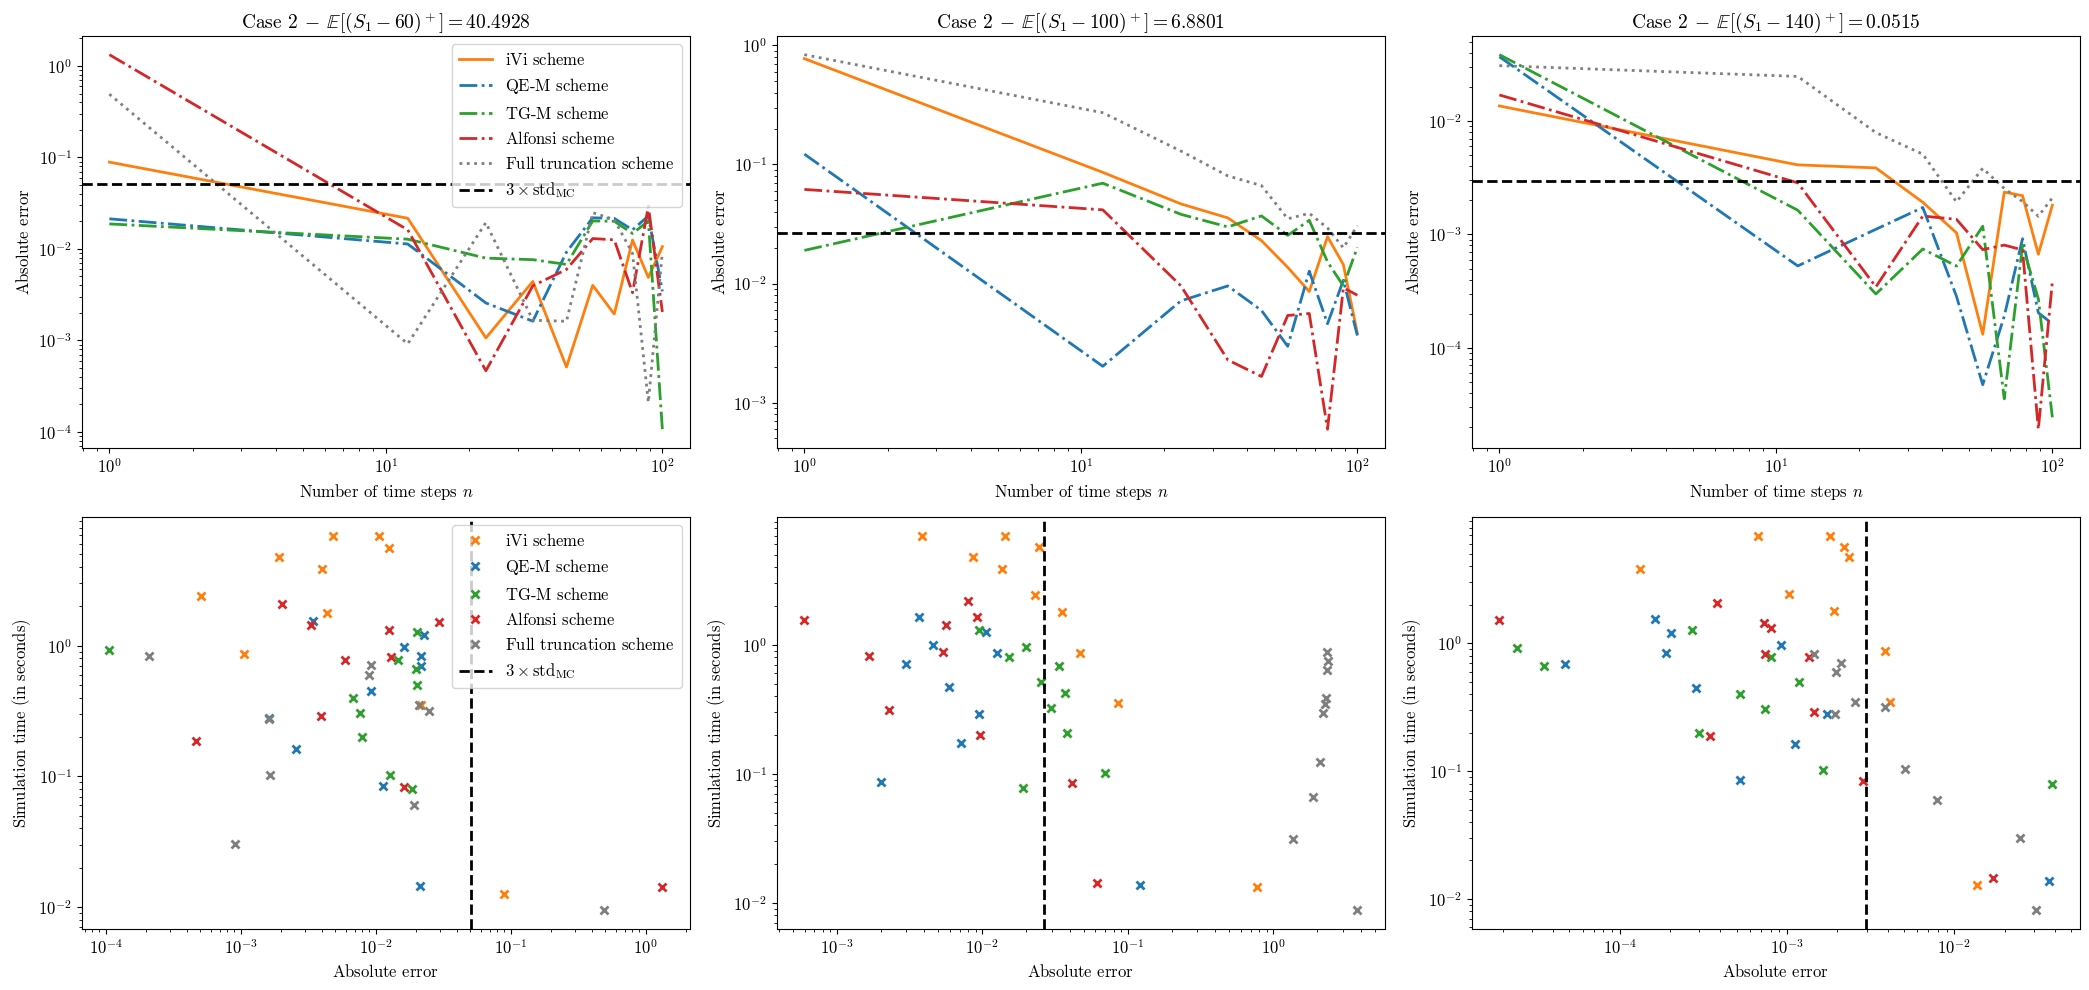

In [111]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
ax = ax.flatten()

ax[0].loglog(n_range, np.abs(true_price_2_ITM - hat_price_2_ITM), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[0].loglog(n_range, np.abs(true_price_2_ITM - QE_price_2_ITM), lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[0].loglog(n_range, np.abs(true_price_2_ITM - TG_price_2_ITM), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[0].loglog(n_range, np.abs(true_price_2_ITM - AL_price_2_ITM), lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[0].loglog(n_range, np.abs(true_price_2_ITM - naive_price_2_ITM), lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[0].axhline(hat_3_std_price_2_ITM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[0].set_title(r"$\text{Case 2}\:-\:\mathbb{E}[(S_1-60)^+] = 40.4928$", fontsize=14)

ax[1].loglog(n_range, np.abs(true_price_2_ATM - hat_price_2_ATM), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[1].loglog(n_range, np.abs(true_price_2_ATM - QE_price_2_ATM), lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[1].loglog(n_range, np.abs(true_price_2_ATM - TG_price_2_ATM), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[1].loglog(n_range, np.abs(true_price_2_ATM - AL_price_2_ATM), lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[1].loglog(n_range, np.abs(true_price_2_ATM - naive_price_2_ATM), lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[1].axhline(hat_3_std_price_2_ATM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[1].set_title(r"$\text{Case 2}\:-\:\mathbb{E}[(S_1-100)^+] =6.8801 $", fontsize=14)

ax[2].loglog(n_range, np.abs(true_price_2_OTM - hat_price_2_OTM), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[2].loglog(n_range, np.abs(true_price_2_OTM - QE_price_2_OTM), lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[2].loglog(n_range, np.abs(true_price_2_OTM - TG_price_2_OTM), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[2].loglog(n_range, np.abs(true_price_2_OTM - AL_price_2_OTM), lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[2].loglog(n_range, np.abs(true_price_2_OTM - naive_price_2_OTM), lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[2].axhline(hat_3_std_price_2_OTM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[2].set_title(r"$\text{Case 2}\:-\:\mathbb{E}[(S_1-140)^+] = 0.0515$", fontsize=14)

ax[3].loglog(np.abs(true_price_2_ITM - hat_price_2_ITM)[::-1], hat_time_2_ITM[::-1], "x", markeredgewidth=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[3].loglog(np.abs(true_price_2_ITM - QE_price_2_ITM)[::-1], QE_time_2_ITM[::-1], "x", markeredgewidth=2, color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[3].loglog(np.abs(true_price_2_ITM - TG_price_2_ITM)[::-1], TG_time_2_ITM[::-1], "x", markeredgewidth=2, color="tab:green", label=r"$\text{TG-M scheme}$")
ax[3].loglog(np.abs(true_price_2_ITM - AL_price_2_ITM)[::-1], AL_time_2_ITM[::-1], "x", markeredgewidth=2, color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[3].loglog(np.abs(true_price_2_ITM - naive_price_2_ITM)[::-1], naive_time_2_ITM[::-1], "x", markeredgewidth=2, color="tab:gray", label=r"$\text{Full truncation scheme}$")
ax[3].axvline(hat_3_std_price_2_ITM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

ax[4].loglog(np.abs(true_price_2_ATM - hat_price_2_ATM)[::-1], hat_time_2_ATM[::-1], "x", markeredgewidth=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[4].loglog(np.abs(true_price_2_ATM - QE_price_2_ATM)[::-1], QE_time_2_ATM[::-1], "x", markeredgewidth=2, color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[4].loglog(np.abs(true_price_2_ATM - TG_price_2_ATM)[::-1], TG_time_2_ATM[::-1], "x", markeredgewidth=2, color="tab:green", label=r"$\text{TG-M scheme}$")
ax[4].loglog(np.abs(true_price_2_ATM - AL_price_2_ATM)[::-1], AL_time_2_ATM[::-1], "x", markeredgewidth=2, color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[4].loglog(np.abs(true_price_2_ATM - naive_price_1_ATM)[::-1], naive_time_2_ATM[::-1], "x", markeredgewidth=2, color="tab:gray", label=r"$\text{Full truncation scheme}$")
ax[4].axvline(hat_3_std_price_2_ATM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

ax[5].loglog(np.abs(true_price_2_OTM - hat_price_2_OTM)[::-1], hat_time_2_OTM[::-1], "x", markeredgewidth=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[5].loglog(np.abs(true_price_2_OTM - QE_price_2_OTM)[::-1], QE_time_2_OTM[::-1], "x", markeredgewidth=2, color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[5].loglog(np.abs(true_price_2_OTM - TG_price_2_OTM)[::-1], TG_time_2_OTM[::-1], "x", markeredgewidth=2, color="tab:green", label=r"$\text{TG-M scheme}$")
ax[5].loglog(np.abs(true_price_2_OTM - AL_price_2_OTM)[::-1], AL_time_2_OTM[::-1], "x", markeredgewidth=2, color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[5].loglog(np.abs(true_price_2_OTM - naive_price_2_OTM)[::-1], naive_time_2_OTM[::-1], "x", markeredgewidth=2, color="tab:gray", label=r"$\text{Full truncation scheme}$")
ax[5].axvline(hat_3_std_price_2_OTM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

for i in range(3) : 
    ax[i].set_ylabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Number of time steps } n$", fontsize=12)
    
for i in range(3, 6) : 
    ax[i].set_xlabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_ylabel(r"$\text{Simulation time (in seconds)}$", fontsize=12)

for i in range(6) : 
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$"))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"$10^{{{int(np.log10(y))}}}$"))
    ax[i].tick_params(axis='both', labelsize=12)

ax[0].legend(loc="upper right", fontsize=12)
ax[3].legend(loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()

##### Case 3 

In [91]:
V0, a, b, c, rho, T = 0.04, 0.5*0.04, -0.5, 1.0, -0.9, 10
S0 = 100

alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)

In [93]:
hat_price_3_ITM, naive_price_3_ITM, QE_price_3_ITM, TG_price_3_ITM, AL_price_3_ITM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
hat_price_3_ATM, naive_price_3_ATM, QE_price_3_ATM, TG_price_3_ATM, AL_price_3_ATM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
hat_price_3_OTM, naive_price_3_OTM, QE_price_3_OTM, TG_price_3_OTM, AL_price_3_OTM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))

hat_time_3_ITM, naive_time_3_ITM, QE_time_3_ITM, TG_time_3_ITM, AL_time_3_ITM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
hat_time_3_ATM, naive_time_3_ATM, QE_time_3_ATM, TG_time_3_ATM, AL_time_3_ATM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))
hat_time_3_OTM, naive_time_3_OTM, QE_time_3_OTM, TG_time_3_OTM, AL_time_3_OTM = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))

for i, n in enumerate(tqdm(n_range)) :
    start = time.time()
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N_values[i][:, :, 0], eta_values[i])
    hat_S = simulate_hat_S(hat_U, hat_Z, S0, rho, N_values[i][:, :, 1])
    common_hat = time.time() - start 

    start = time.time()
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 100, 0.0))
    hat_price_3_ATM[i] = mean
    hat_time_3_ATM[i] = common_hat + time.time() - start 
    if i == len(n_range)-1 : 
        hat_3_std_price_3_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 60, 0.0))
    hat_price_3_ITM[i] = mean
    hat_time_3_ITM[i] = common_hat + time.time() - start 
    if i == len(n_range)-1 : 
        hat_3_std_price_3_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 140, 0.0))
    hat_price_3_OTM[i] = mean
    hat_time_3_OTM[i] = common_hat + time.time() - start 
    if i == len(n_range)-1 : 
        hat_3_std_price_3_OTM = 3 * np.sqrt(var/M)

    start = time.time() 
    S, V = simulate_full_truncation(T, S0, V0, a, b, c, rho, N_values[i])
    common_naive = time.time() - start 

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    naive_price_3_ATM[i] = mean
    naive_time_3_ATM[i] = common_naive + time.time() - start 
    if i == len(n_range)-1 : 
        hat_3_std_price_3_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    naive_price_3_ITM[i] = mean
    naive_time_3_ITM[i] = common_naive + time.time() - start 
    if i == len(n_range)-1 : 
        naive_3_std_price_3_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    naive_price_3_OTM[i] = mean
    naive_time_3_OTM[i] = common_naive + time.time() - start 
    if i == len(n_range)-1 :
        naive_3_std_price_3_OTM = 3 * np.sqrt(var/M)

    start = time.time() 
    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i])
    common_QE = time.time() - start 

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    QE_price_3_ATM[i] = mean
    QE_time_3_ATM[i] = common_QE + time.time() - start 
    if i == len(n_range)-1 : 
        QE_3_std_price_3_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    QE_price_3_ITM[i] = mean
    QE_time_3_ITM[i] = common_QE + time.time() - start 
    if i == len(n_range)-1 : 
        QE_3_std_price_3_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    QE_price_3_OTM[i] = mean
    QE_time_3_OTM[i] = common_QE + time.time() - start 
    if i == len(n_range)-1 :
        QE_3_std_price_3_OTM = 3 * np.sqrt(var/M)

    start = time.time() 
    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], alpha, f_mu_values, f_sigma_values)
    common_TG = time.time() - start 
    
    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    TG_price_3_ATM[i] = mean
    TG_time_3_ATM[i] = common_TG + time.time() - start 
    if i == len(n_range)-1 : 
        TG_3_std_price_3_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    TG_price_3_ITM[i] = mean
    TG_time_3_ITM[i] = common_TG + time.time() - start 
    if i == len(n_range)-1 : 
        TG_3_std_price_3_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    TG_price_3_OTM[i] = mean
    TG_time_3_OTM[i] = common_TG + time.time() - start 
    if i == len(n_range)-1 :
        TG_3_std_price_3_OTM = 3 * np.sqrt(var/M)

    start = time.time()
    S, _, V = simulate_AL(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], bernoulli_values[i])
    common_AL = time.time() - start 

    start = time.time()
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    AL_price_3_ATM[i] = mean
    AL_time_3_ATM[i] = common_AL + time.time() - start 
    if i == len(n_range)-1 : 
        AL_3_std_price_3_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    AL_price_3_ITM[i] = mean
    AL_time_3_ITM[i] = common_AL + time.time() - start 
    if i == len(n_range)-1 : 
        AL_3_std_price_3_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    AL_price_3_OTM[i] = mean
    AL_time_3_OTM[i] = common_AL + time.time() - start 
    if i == len(n_range)-1 : 
        AL_3_std_price_3_OTM = 3 * np.sqrt(var/M)

100%|███████████████████████████████████████████| 10/10 [00:59<00:00,  5.92s/it]


In [94]:
true_price_3_ITM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 60, 150, flag="call")
true_price_3_ATM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 100, 150, flag="call")
true_price_3_OTM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 140, 150, flag="call")
true_price_3_ITM, true_price_3_ATM, true_price_3_OTM

(44.32997506623403, 13.084670132052992, 0.2957744298733047)

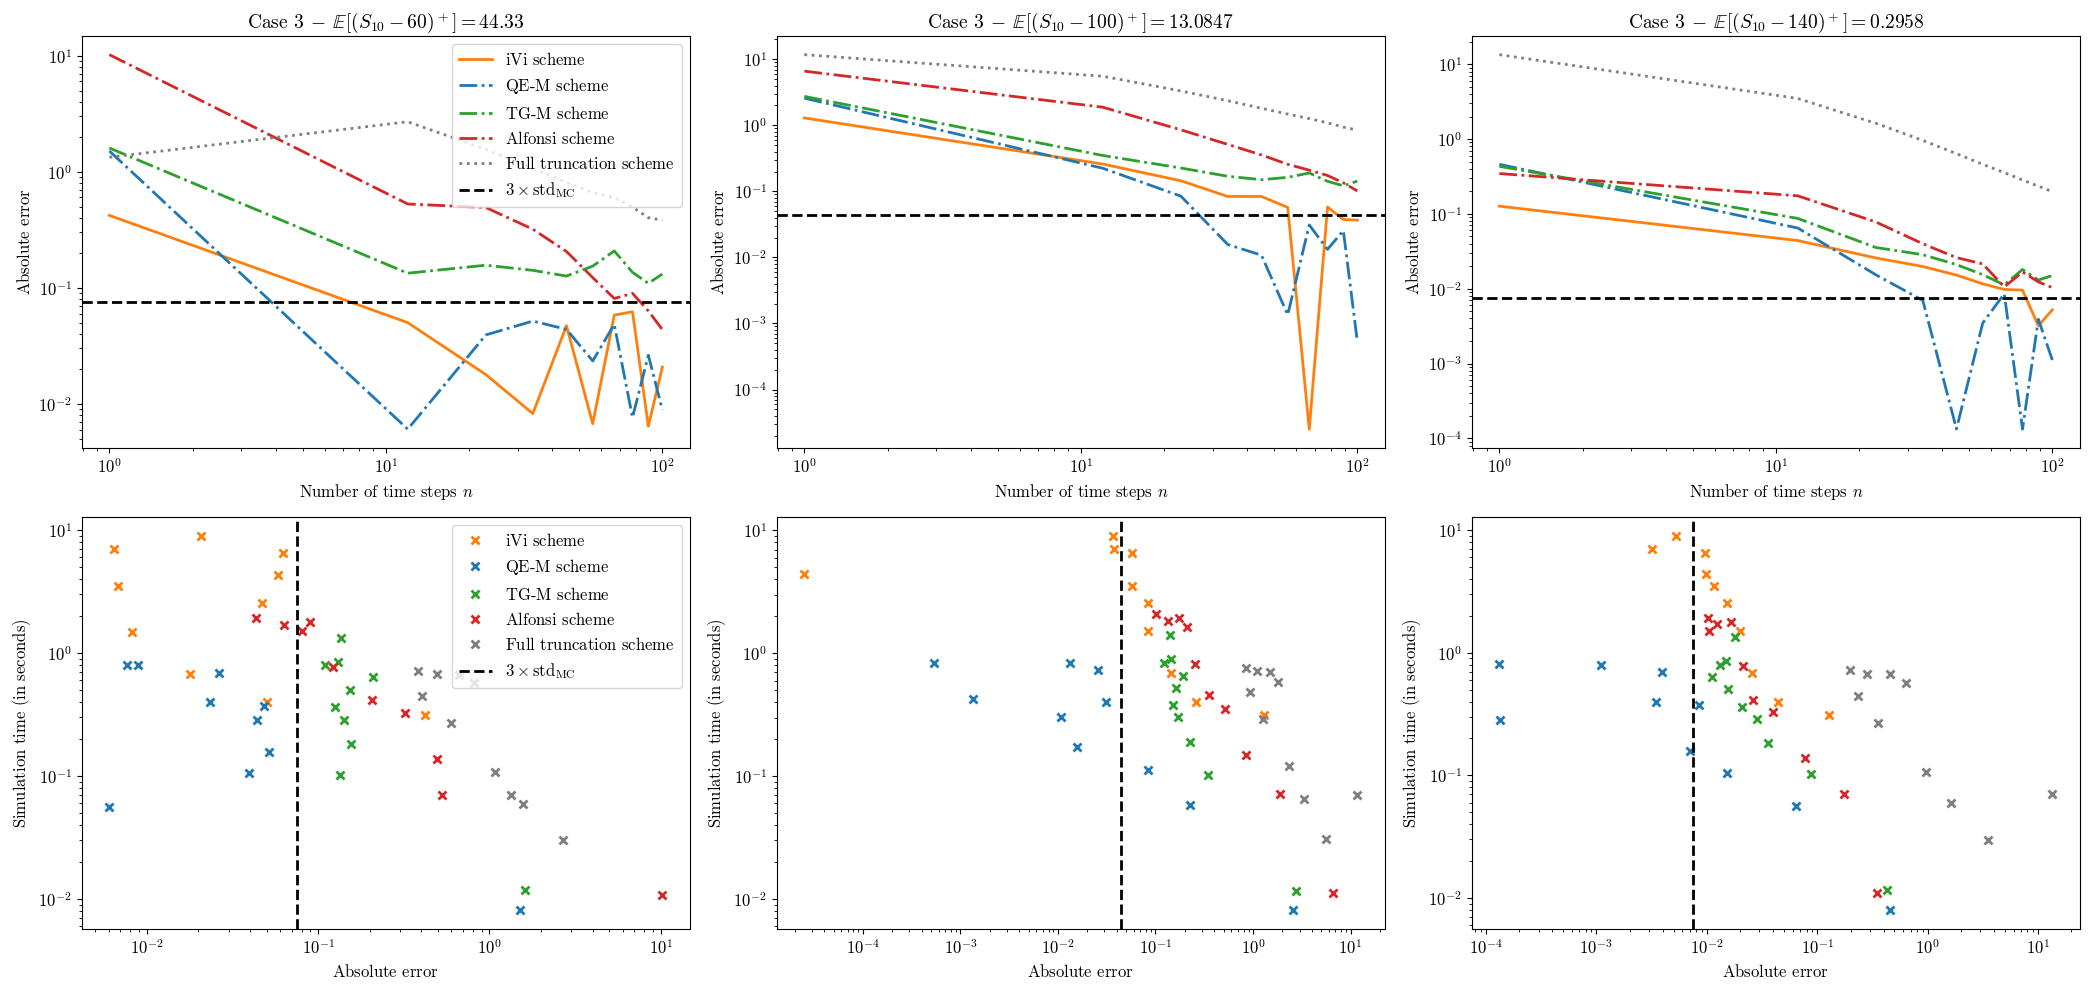

In [101]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
ax = ax.flatten()

ax[0].loglog(n_range, np.abs(true_price_3_ITM - hat_price_3_ITM), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[0].loglog(n_range, np.abs(true_price_3_ITM - QE_price_3_ITM), lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[0].loglog(n_range, np.abs(true_price_3_ITM - TG_price_3_ITM), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[0].loglog(n_range, np.abs(true_price_3_ITM - AL_price_3_ITM), lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[0].loglog(n_range, np.abs(true_price_3_ITM - naive_price_3_ITM), lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[0].axhline(hat_3_std_price_3_ITM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[0].set_title(r"$\text{Case 3}\:-\:\mathbb{E}[(S_{10}-60)^+] = 44.33$", fontsize=14)

ax[1].loglog(n_range, np.abs(true_price_3_ATM - hat_price_3_ATM), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[1].loglog(n_range, np.abs(true_price_3_ATM - QE_price_3_ATM), lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[1].loglog(n_range, np.abs(true_price_3_ATM - TG_price_3_ATM), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[1].loglog(n_range, np.abs(true_price_3_ATM - AL_price_3_ATM), lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[1].loglog(n_range, np.abs(true_price_3_ATM - naive_price_3_ATM), lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[1].axhline(hat_3_std_price_3_ATM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[1].set_title(r"$\text{Case 3}\:-\:\mathbb{E}[(S_{10}-100)^+] =13.0847$", fontsize=14)

ax[2].loglog(n_range, np.abs(true_price_3_OTM - hat_price_3_OTM), lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[2].loglog(n_range, np.abs(true_price_3_OTM - QE_price_3_OTM), lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[2].loglog(n_range, np.abs(true_price_3_OTM - TG_price_3_OTM), lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[2].loglog(n_range, np.abs(true_price_3_OTM - AL_price_3_OTM), lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[2].loglog(n_range, np.abs(true_price_3_OTM - naive_price_3_OTM), lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[2].axhline(hat_3_std_price_3_OTM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[2].set_title(r"$\text{Case 3}\:-\:\mathbb{E}[(S_{10}-140)^+] = 0.2958$", fontsize=14)

ax[3].loglog(np.abs(true_price_3_ITM - hat_price_3_ITM)[::-1], hat_time_3_ITM[::-1], "x", markeredgewidth=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[3].loglog(np.abs(true_price_3_ITM - QE_price_3_ITM)[::-1], QE_time_3_ITM[::-1], "x", markeredgewidth=2, color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[3].loglog(np.abs(true_price_3_ITM - TG_price_3_ITM)[::-1], TG_time_3_ITM[::-1], "x", markeredgewidth=2, color="tab:green", label=r"$\text{TG-M scheme}$")
ax[3].loglog(np.abs(true_price_3_ITM - AL_price_3_ITM)[::-1], AL_time_3_ITM[::-1], "x", markeredgewidth=2, color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[3].loglog(np.abs(true_price_3_ITM - naive_price_3_ITM)[::-1], naive_time_3_ITM[::-1], "x", markeredgewidth=2, color="tab:gray", label=r"$\text{Full truncation scheme}$")
ax[3].axvline(hat_3_std_price_3_ITM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

ax[4].loglog(np.abs(true_price_3_ATM - hat_price_3_ATM)[::-1], hat_time_3_ATM[::-1], "x", markeredgewidth=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[4].loglog(np.abs(true_price_3_ATM - QE_price_3_ATM)[::-1], QE_time_3_ATM[::-1], "x", markeredgewidth=2, color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[4].loglog(np.abs(true_price_3_ATM - TG_price_3_ATM)[::-1], TG_time_3_ATM[::-1], "x", markeredgewidth=2, color="tab:green", label=r"$\text{TG-M scheme}$")
ax[4].loglog(np.abs(true_price_3_ATM - AL_price_3_ATM)[::-1], AL_time_3_ATM[::-1], "x", markeredgewidth=2, color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[4].loglog(np.abs(true_price_3_ATM - naive_price_3_ATM)[::-1], naive_time_3_ATM[::-1], "x", markeredgewidth=2, color="tab:gray", label=r"$\text{Full truncation scheme}$")
ax[4].axvline(hat_3_std_price_3_ATM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

ax[5].loglog(np.abs(true_price_3_OTM - hat_price_3_OTM)[::-1], hat_time_3_OTM[::-1], "x", markeredgewidth=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[5].loglog(np.abs(true_price_3_OTM - QE_price_3_OTM)[::-1], QE_time_3_OTM[::-1], "x", markeredgewidth=2, color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[5].loglog(np.abs(true_price_3_OTM - TG_price_3_OTM)[::-1], TG_time_3_OTM[::-1], "x", markeredgewidth=2, color="tab:green", label=r"$\text{TG-M scheme}$")
ax[5].loglog(np.abs(true_price_3_OTM - AL_price_3_OTM)[::-1], AL_time_3_OTM[::-1], "x", markeredgewidth=2, color="tab:red", label=r"$\text{Alfonsi scheme}$")
ax[5].loglog(np.abs(true_price_3_OTM - naive_price_3_OTM)[::-1], naive_time_3_OTM[::-1], "x", markeredgewidth=2, color="tab:gray", label=r"$\text{Full truncation scheme}$")
ax[5].axvline(hat_3_std_price_3_OTM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

for i in range(3) : 
    ax[i].set_ylabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Number of time steps } n$", fontsize=12)
    
for i in range(3, 6) : 
    ax[i].set_xlabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_ylabel(r"$\text{Simulation time (in seconds)}$", fontsize=12)

for i in range(6) : 
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$"))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"$10^{{{int(np.log10(y))}}}$"))
    ax[i].tick_params(axis='both', labelsize=12)

ax[0].legend(loc="upper right", fontsize=12)
ax[3].legend(loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()

##### As a function of the number of sample paths with $n=50$

In [124]:
M_range = np.array([10, 25, 50, 100, 125, 150, 175, 200]) * 1000
n = 50

N_values = []
eta_values = [] 
bernoulli_values = []

for M in tqdm(M_range) : 
    N_values.append(simulate_antithetic_d(M, n, 2))
    eta_values.append(np.random.uniform(size=(M, n)))
    bernoulli_values.append(np.random.binomial(n=1, p=0.5, size=(M, n)))

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.54it/s]


In [126]:
V0, a, b, c, rho, T = 0.006, 17.25*0.018, -17.25, 2.95, -0.68, 1
S0 = 100

alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)

In [128]:
hat_price_1_ITM, naive_price_1_ITM, QE_price_1_ITM, TG_price_1_ITM, AL_price_1_ITM = np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range))
hat_price_1_ATM, naive_price_1_ATM, QE_price_1_ATM, TG_price_1_ATM, AL_price_1_ATM = np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range))
hat_price_1_OTM, naive_price_1_OTM, QE_price_1_OTM, TG_price_1_OTM, AL_price_1_OTM = np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range))

for i, M in enumerate(tqdm(M_range)) :
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N_values[i][:, :, 0], eta_values[i])
    hat_S = simulate_hat_S(hat_U, hat_Z, S0, rho, N_values[i][:, :, 1])
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 100, 0.0))
    hat_price_1_ATM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 60, 0.0))
    hat_price_1_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 140, 0.0))
    hat_price_1_OTM[i] = mean 

    S, V = simulate_full_truncation(T, S0, V0, a, b, c, rho, N_values[i])
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    naive_price_1_ATM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    naive_price_1_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    naive_price_1_OTM[i] = mean

    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i]) 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    QE_price_1_ATM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    QE_price_1_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    QE_price_1_OTM[i] = mean

    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], alpha, f_mu_values, f_sigma_values)
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    TG_price_1_ATM[i] = mean 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    TG_price_1_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    TG_price_1_OTM[i] = mean

    S, _, V = simulate_AL(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], bernoulli_values[i])
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    AL_price_1_ATM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    AL_price_1_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    AL_price_1_OTM[i] = mean

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  6.12it/s]


In [129]:
true_price_1_ITM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 60, 150, flag="call")
true_price_1_ATM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 100, 150, flag="call")
true_price_1_OTM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 140, 150, flag="call")
true_price_1_ITM, true_price_1_ATM, true_price_1_OTM

(40.1162938845335, 4.345385427983771, 0.0014843170361160674)

In [130]:
V0, a, b, c, rho, T = 0.023, 2.15*0.057, -2.15, 0.86, -0.70, 1
S0 = 100

alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)

In [131]:
hat_price_2_ITM, naive_price_2_ITM, QE_price_2_ITM, TG_price_2_ITM, AL_price_2_ITM = np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range))
hat_price_2_ATM, naive_price_2_ATM, QE_price_2_ATM, TG_price_2_ATM, AL_price_2_ATM = np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range))
hat_price_2_OTM, naive_price_2_OTM, QE_price_2_OTM, TG_price_2_OTM, AL_price_2_OTM = np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range))

for i, M in enumerate(tqdm(M_range)) :
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N_values[i][:, :, 0], eta_values[i])
    hat_S = simulate_hat_S(hat_U, hat_Z, S0, rho, N_values[i][:, :, 1])
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 100, 0.0))
    hat_price_2_ATM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 60, 0.0))
    hat_price_2_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 140, 0.0))
    hat_price_2_OTM[i] = mean

    S, V = simulate_full_truncation(T, S0, V0, a, b, c, rho, N_values[i])
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    naive_price_2_ATM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    naive_price_2_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    naive_price_2_OTM[i] = mean

    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i]) 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    QE_price_2_ATM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    QE_price_2_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    QE_price_2_OTM[i] = mean

    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], alpha, f_mu_values, f_sigma_values)
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    TG_price_2_ATM[i] = mean 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    TG_price_2_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    TG_price_2_OTM[i] = mean

    S, _, V = simulate_AL(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], bernoulli_values[i])
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    AL_price_2_ATM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    AL_price_2_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    AL_price_2_OTM[i] = mean

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.88it/s]


In [132]:
true_price_2_ITM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 60, 150, flag="call")
true_price_2_ATM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 100, 150, flag="call")
true_price_2_OTM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 140, 150, flag="call")
true_price_2_ITM, true_price_2_ATM, true_price_2_OTM

(40.492754832404195, 6.88014184558115, 0.0514839841441983)

In [136]:
V0, a, b, c, rho, T = 0.04, 0.5*0.04, -0.5, 1.0, -0.9, 10
S0 = 100

alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)

In [137]:
hat_price_3_ITM, naive_price_3_ITM, QE_price_3_ITM, TG_price_3_ITM, AL_price_3_ITM = np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range))
hat_price_3_ATM, naive_price_3_ATM, QE_price_3_ATM, TG_price_3_ATM, AL_price_3_ATM = np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range))
hat_price_3_OTM, naive_price_3_OTM, QE_price_3_OTM, TG_price_3_OTM, AL_price_3_OTM = np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range)), np.zeros(len(M_range))

for i, M in enumerate(tqdm(M_range)) :
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N_values[i][:, :, 0], eta_values[i])
    hat_S = simulate_hat_S(hat_U, hat_Z, S0, rho, N_values[i][:, :, 1])
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 100, 0.0))
    hat_price_3_ATM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 60, 0.0))
    hat_price_3_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(hat_S[:, -1] - 140, 0.0))
    hat_price_3_OTM[i] = mean

    S, V = simulate_full_truncation(T, S0, V0, a, b, c, rho, N_values[i])
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    naive_price_3_ATM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    naive_price_3_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    naive_price_3_OTM[i] = mean

    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i]) 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    QE_price_3_ATM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    QE_price_3_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    QE_price_3_OTM[i] = mean

    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], alpha, f_mu_values, f_sigma_values)
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    TG_price_3_ATM[i] = mean 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    TG_price_3_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    TG_price_3_OTM[i] = mean

    S, _, V = simulate_AL(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], bernoulli_values[i])
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    AL_price_3_ATM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    AL_price_3_ITM[i] = mean
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    AL_price_3_OTM[i] = mean

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  6.68it/s]


In [138]:
true_price_3_ITM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 60, 150, flag="call")
true_price_3_ATM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 100, 150, flag="call")
true_price_3_OTM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 140, 150, flag="call")
true_price_3_ITM, true_price_3_ATM, true_price_3_OTM

(44.32997506623403, 13.084670132052992, 0.2957744298733047)

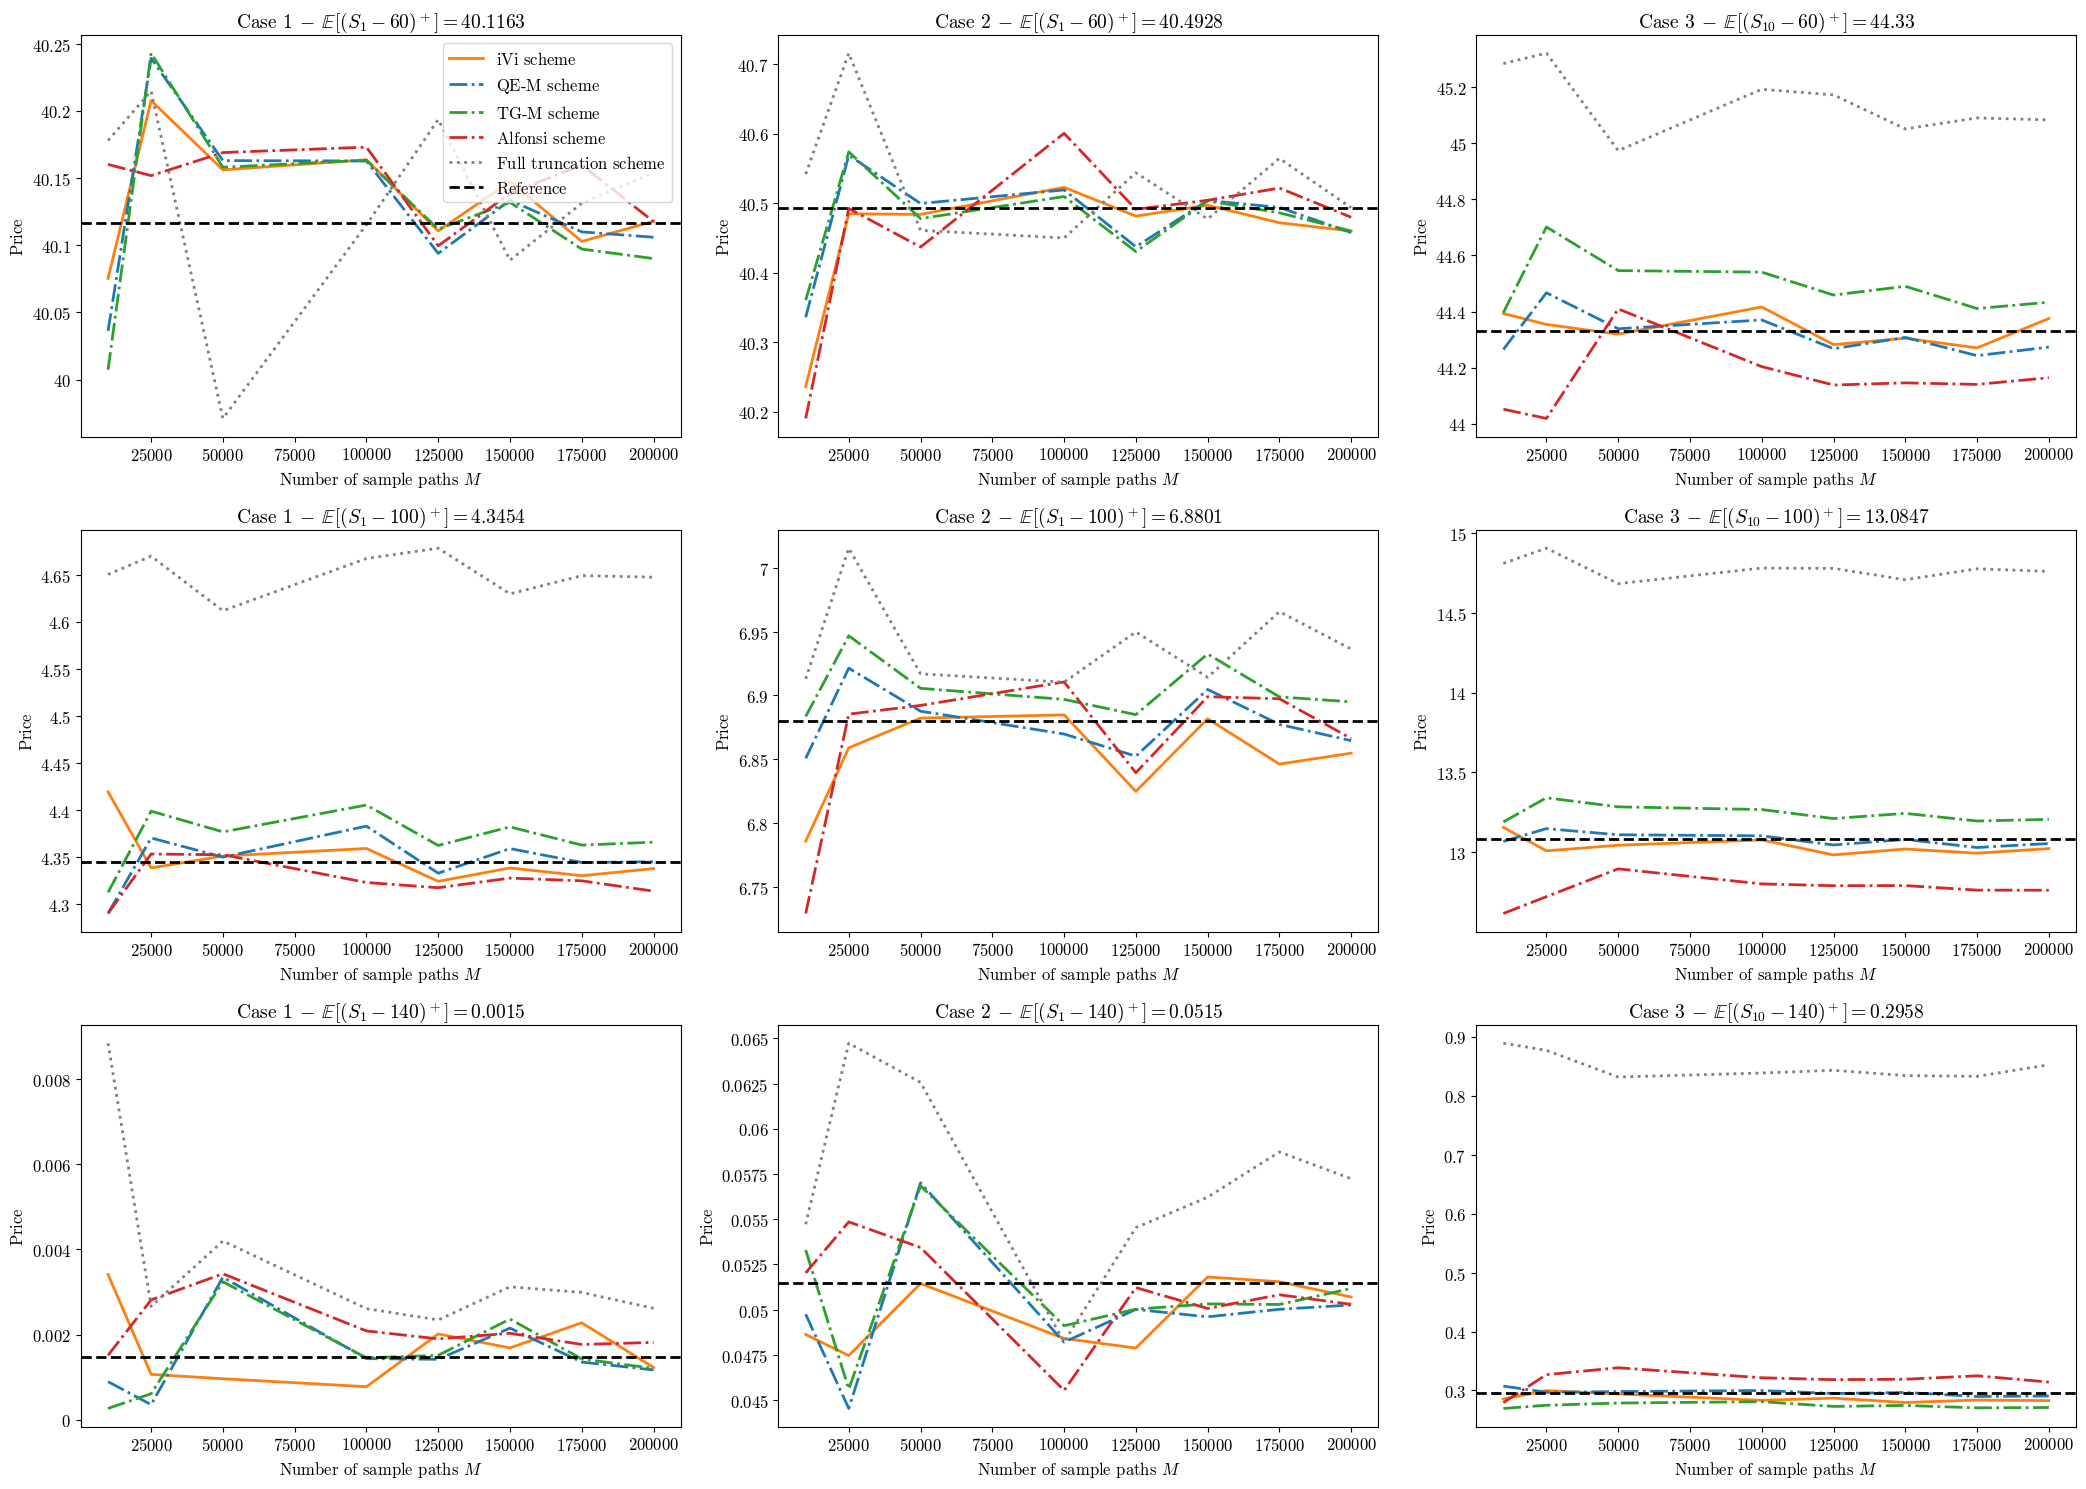

In [148]:
fig, ax = plt.subplots(3, 3, figsize=(21, 15))
ax = ax.flatten() 

ax[0].plot(M_range, hat_price_1_ITM, lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[0].plot(M_range, QE_price_1_ITM, lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[0].plot(M_range, TG_price_1_ITM, lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[0].plot(M_range, AL_price_1_ITM, lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[0].plot(M_range, naive_price_1_ITM, lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[0].axhline(true_price_1_ITM, lw=2, color="black", linestyle="--", label=r"$\text{Reference}$")
ax[0].set_title(r"$\text{Case 1}\:-\:\mathbb{E}[(S_1-60)^+] = 40.1163$", fontsize=14)

ax[1].plot(M_range, hat_price_2_ITM, lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[1].plot(M_range, QE_price_2_ITM, lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[1].plot(M_range, TG_price_2_ITM, lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[1].plot(M_range, AL_price_2_ITM, lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[1].plot(M_range, naive_price_2_ITM, lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[1].axhline(true_price_2_ITM, lw=2, color="black", linestyle="--", label=r"$\text{Reference}$")
ax[1].set_title(r"$\text{Case 2}\:-\:\mathbb{E}[(S_1-60)^+] = 40.4928$", fontsize=14)

ax[2].plot(M_range, hat_price_3_ITM, lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[2].plot(M_range, QE_price_3_ITM, lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[2].plot(M_range, TG_price_3_ITM, lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[2].plot(M_range, AL_price_3_ITM, lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[2].plot(M_range, naive_price_3_ITM, lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[2].axhline(true_price_3_ITM, lw=2, color="black", linestyle="--", label=r"$\text{Reference}$")
ax[2].set_title(r"$\text{Case 3}\:-\:\mathbb{E}[(S_{10}-60)^+] = 44.33$", fontsize=14)

ax[3].plot(M_range, hat_price_1_ATM, lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[3].plot(M_range, QE_price_1_ATM, lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[3].plot(M_range, TG_price_1_ATM, lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[3].plot(M_range, AL_price_1_ATM, lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[3].plot(M_range, naive_price_1_ATM, lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[3].axhline(true_price_1_ATM, lw=2, color="black", linestyle="--", label=r"$\text{Reference}$")
ax[3].set_title(r"$\text{Case 1}\:-\:\mathbb{E}[(S_1-100)^+] = 4.3454$", fontsize=14)

ax[4].plot(M_range, hat_price_2_ATM, lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[4].plot(M_range, QE_price_2_ATM, lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[4].plot(M_range, TG_price_2_ATM, lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[4].plot(M_range, AL_price_2_ATM, lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[4].plot(M_range, naive_price_2_ATM, lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[4].axhline(true_price_2_ATM, lw=2, color="black", linestyle="--", label=r"$\text{Reference}$")
ax[4].set_title(r"$\text{Case 2}\:-\:\mathbb{E}[(S_1-100)^+] = 6.8801$", fontsize=14)

ax[5].plot(M_range, hat_price_3_ATM, lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[5].plot(M_range, QE_price_3_ATM, lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[5].plot(M_range, TG_price_3_ATM, lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[5].plot(M_range, AL_price_3_ATM, lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[5].plot(M_range, naive_price_3_ATM, lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[5].axhline(true_price_3_ATM, lw=2, color="black", linestyle="--", label=r"$\text{Reference}$")
ax[5].set_title(r"$\text{Case 3}\:-\:\mathbb{E}[(S_{10}-100)^+] = 13.0847$", fontsize=14)

ax[6].plot(M_range, hat_price_1_OTM, lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[6].plot(M_range, QE_price_1_OTM, lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[6].plot(M_range, TG_price_1_OTM, lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[6].plot(M_range, AL_price_1_OTM, lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[6].plot(M_range, naive_price_1_OTM, lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[6].axhline(true_price_1_OTM, lw=2, color="black", linestyle="--", label=r"$\text{Reference}$")
ax[6].set_title(r"$\text{Case 1}\:-\:\mathbb{E}[(S_1-140)^+] = 0.0015$", fontsize=14)

ax[7].plot(M_range, hat_price_2_OTM, lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[7].plot(M_range, QE_price_2_OTM, lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[7].plot(M_range, TG_price_2_OTM, lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[7].plot(M_range, AL_price_2_OTM, lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[7].plot(M_range, naive_price_2_OTM, lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[7].axhline(true_price_2_OTM, lw=2, color="black", linestyle="--", label=r"$\text{Reference}$")
ax[7].set_title(r"$\text{Case 2}\:-\:\mathbb{E}[(S_1-140)^+] = 0.0515$", fontsize=14)

ax[8].plot(M_range, hat_price_3_OTM, lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
ax[8].plot(M_range, QE_price_3_OTM, lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
ax[8].plot(M_range, TG_price_3_OTM, lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
ax[8].plot(M_range, AL_price_3_OTM, lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
ax[8].plot(M_range, naive_price_3_OTM, lw=2, color="tab:gray", linestyle =":", label=r"$\text{Full truncation scheme}$")
ax[8].axhline(true_price_3_OTM, lw=2, color="black", linestyle="--", label=r"$\text{Reference}$")
ax[8].set_title(r"$\text{Case 3}\:-\:\mathbb{E}[(S_{10}-140)^+] = 0.2958$", fontsize=14)


for i in range(9) : 
    ax[i].set_xlabel(r"$\text{Number of sample paths }M$", fontsize=12)
    ax[i].set_ylabel(r"$\text{Price}$", fontsize=12)
    ax[i].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].tick_params(axis='both', labelsize=12)

ax[0].legend(loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()

#### IV.2. Implied volatility 

In [5]:
K_range = np.linspace(45, 140, 100)

n_range = np.array([1, 5, 15])
M = 2*int(1e6)

N_values = []
eta_values = [] 
bernoulli_values = []

for n in tqdm(n_range) : 
    N_values.append(simulate_antithetic_d(M, n, 2))
    eta_values.append(np.random.uniform(size=(M, n)))
    bernoulli_values.append(np.random.binomial(n=1, p=0.5, size=(M, n)))

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


##### Case 1 

In [7]:
V0, a, b, c, rho, T = 0.006, 17.25 * 0.018, -17.25, 2.95, -0.68, 1
S0 = 100

## for the TG scheme:  
alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)

In [ ]:
hat_iv, QE_iv, TG_iv, AL_iv = np.zeros((len(n_range), len(K_range))), np.zeros((len(n_range), len(K_range))), np.zeros((len(n_range), len(K_range))), np.zeros((len(n_range), len(K_range)))
hat_MAE, QE_MAE, TG_MAE, AL_MAE = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))

true_iv = compute_IV_Fourier(K_range, T, S0, V0, a, b, c, rho, 150) 

for i, n in enumerate(tqdm(n_range)) : 
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N_values[i][:, :, 0], eta_values[i])
    hat_S = simulate_hat_S(hat_U, hat_Z, S0, rho, N_values[i][:, :, 1])
    mid, _, _ = compute_IV_MC(K_range, T, S0, hat_S[:, -1])
    hat_iv[i,:] = mid
    hat_MAE[i] = np.mean(np.abs(mid - true_iv))

    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i])
    mid, _, _ = compute_IV_MC(K_range, T, S0, S[:, -1])
    QE_iv[i,:] = mid
    QE_MAE[i] = np.mean(np.abs(mid - true_iv))

    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], alpha, f_mu_values, f_sigma_values)
    mid, _, _ = compute_IV_MC(K_range, T, S0, S[:, -1])
    TG_iv[i,:] = mid
    TG_MAE[i] = np.mean(np.abs(mid - true_iv))

    S, _, V = simulate_AL(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], bernoulli_values[i]) 
    mid, _, _ = compute_IV_MC(K_range, T, S0, S[:, -1])
    AL_iv[i,:] = mid
    AL_MAE[i] = np.mean(np.abs(mid - true_iv))
    
S, V = simulate_full_truncation(T, S0, V0, a, b, c, rho, N_values[-1])
mid, _, _ = compute_IV_MC(K_range, T, S0, S[:, -1])
naive_iv =  mid
naive_MAE =  np.mean(np.abs(mid - true_iv))

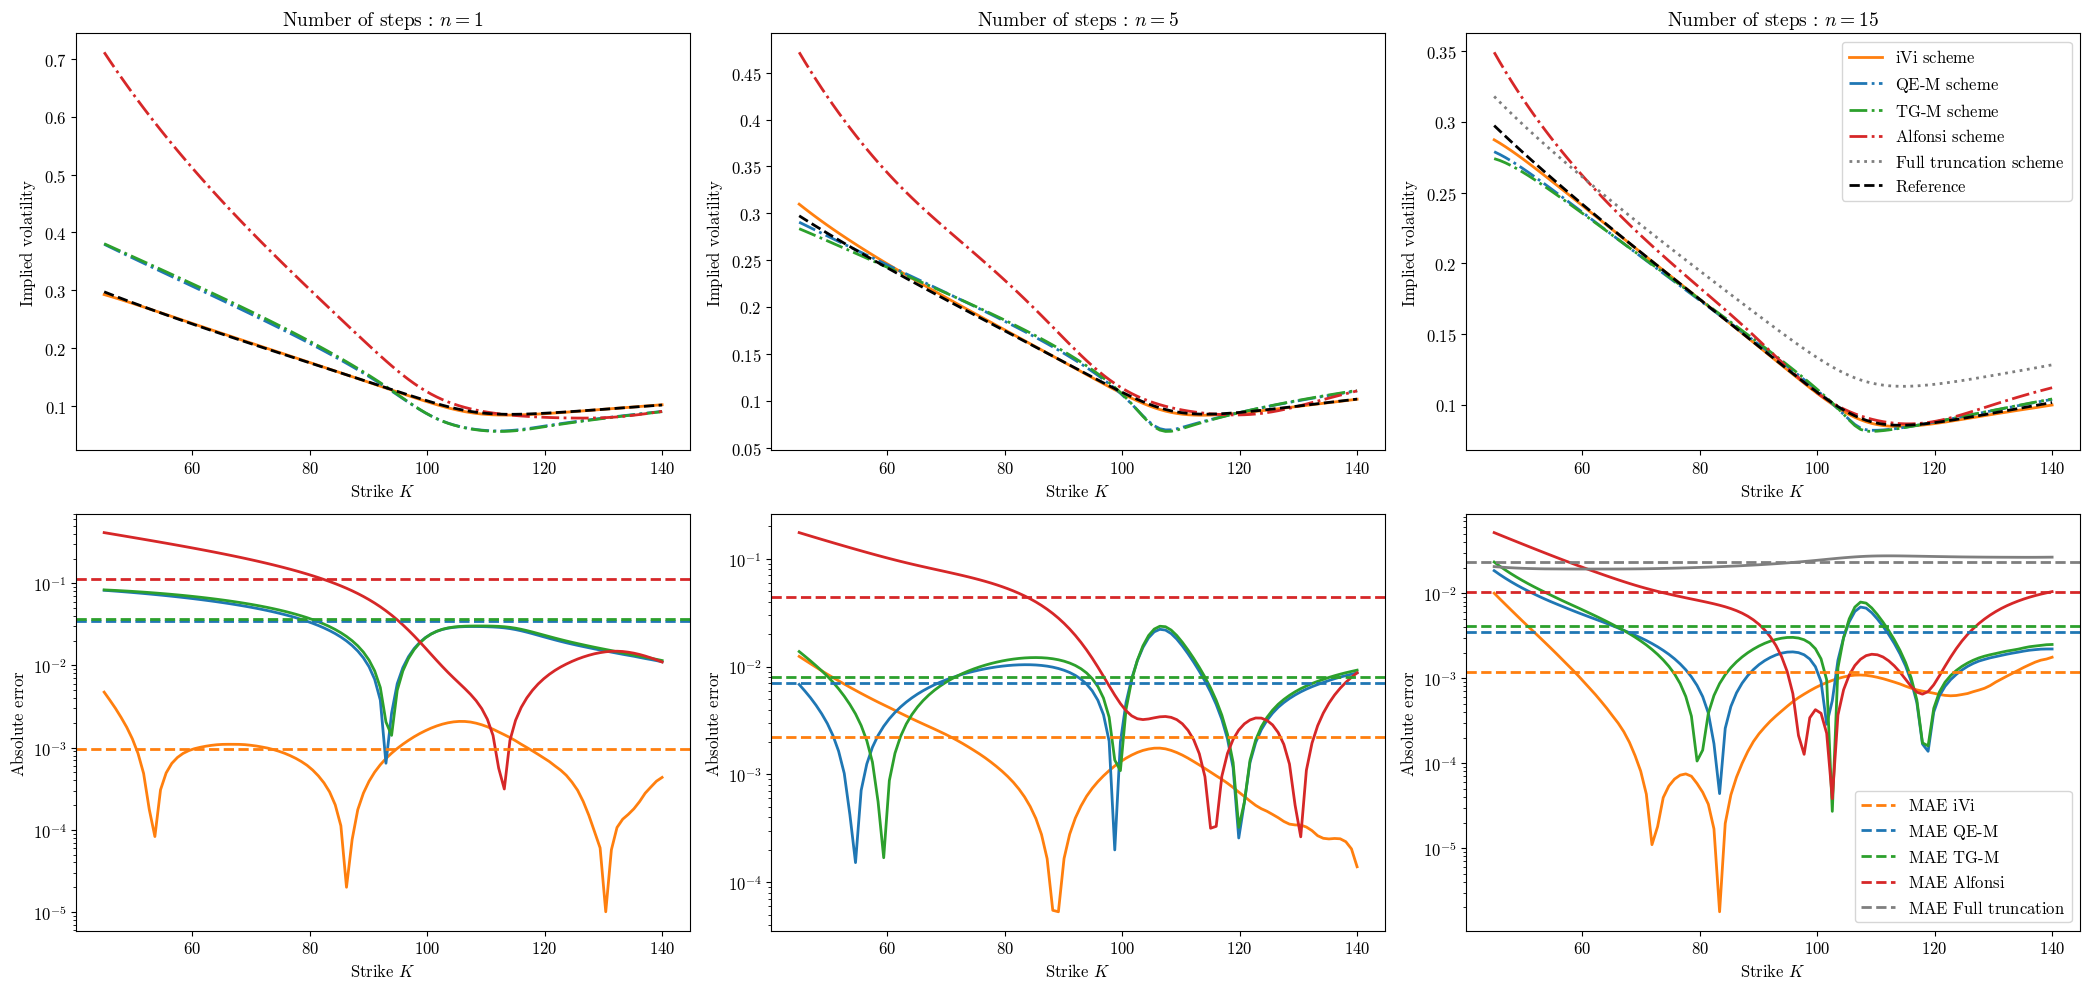

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
ax = ax.flatten()

for i in range(3) : 
    ax[i].plot(K_range, hat_iv[i,:], lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
    ax[i].plot(K_range, QE_iv[i,:], lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
    ax[i].plot(K_range, TG_iv[i,:], lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
    ax[i].plot(K_range, AL_iv[i,:], lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
    if i == 2 : 
        ax[i].plot(K_range, naive_iv, lw=2, color="tab:gray", linestyle=":", label=r"$\text{Full truncation scheme}$")
    ax[i].plot(K_range, true_iv, lw=2, color="black", linestyle="--", label=r"$\text{Reference}$")
    ax[i].set_ylabel(r"$\text{Implied volatility}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Strike }K$", fontsize=12)
    ax[i].set_title(r"$\text{Number of steps : }$" + fr"$n={n_range[i]}$", fontsize=14)
    ax[i].xaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].tick_params(axis='both', labelsize=12)

for i in range(3, 6) :
    ax[i].semilogy(K_range, np.abs(true_iv - hat_iv[i-3,:]), lw=2, color="tab:orange")
    ax[i].semilogy(K_range, np.abs(true_iv - QE_iv[i-3,:]), lw=2, color="tab:blue")
    ax[i].semilogy(K_range, np.abs(true_iv - TG_iv[i-3,:]), lw=2, color="tab:green")
    ax[i].semilogy(K_range, np.abs(true_iv - AL_iv[i-3,:]), lw=2, color="tab:red")
    if i == 5 : 
        ax[i].semilogy(K_range, np.abs(true_iv - naive_iv), lw=2, color="tab:gray")
    ax[i].axhline(hat_MAE[i-3], lw=2, color="tab:orange", linestyle="--", label=r"$\text{MAE iVi}$")
    ax[i].axhline(QE_MAE[i-3], lw=2, color="tab:blue", linestyle="--", label=r"$\text{MAE QE-M}$")
    ax[i].axhline(TG_MAE[i-3], lw=2, color="tab:green", linestyle="--", label=r"$\text{MAE TG-M}$")
    ax[i].axhline(AL_MAE[i-3], lw=2, color="tab:red", linestyle="--", label=r"$\text{MAE Alfonsi}$")
    if i == 5 :
        ax[i].axhline(naive_MAE, lw=2, color="tab:gray", linestyle="--", label=r"$\text{MAE Full truncation}$")
    ax[i].set_ylabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Strike }K$", fontsize=12)
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$"))
    ax[i].xaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].tick_params(axis='both', labelsize=12)

ax[2].legend(loc="upper right", fontsize=12)
ax[5].legend(loc="lower right", fontsize=12)
    

plt.tight_layout()
plt.show()

##### Case 2 

In [25]:
V0, a, b, c, rho, T = 0.023, 2.15 * 0.057, -2.15, 0.86, -0.70, 1
S0 = 100

## for the TG scheme:  
alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)

In [27]:
hat_iv, QE_iv, TG_iv, AL_iv = np.zeros((len(n_range), len(K_range))), np.zeros((len(n_range), len(K_range))), np.zeros((len(n_range), len(K_range))), np.zeros((len(n_range), len(K_range)))
hat_MAE, QE_MAE, TG_MAE, AL_MAE = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))

true_iv = compute_IV_Fourier(K_range, T, S0, V0, a, b, c, rho, 150) 

for i, n in enumerate(tqdm(n_range)) : 
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N_values[i][:, :, 0], eta_values[i])
    hat_S = simulate_hat_S(hat_U, hat_Z, S0, rho, N_values[i][:, :, 1])
    mid, _, _ = compute_IV_MC(K_range, T, S0, hat_S[:, -1])
    hat_iv[i,:] = mid
    hat_MAE[i] = np.mean(np.abs(mid - true_iv))

    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i])
    mid, _, _ = compute_IV_MC(K_range, T, S0, S[:, -1])
    QE_iv[i,:] = mid
    QE_MAE[i] = np.mean(np.abs(mid - true_iv))

    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], alpha, f_mu_values, f_sigma_values)
    mid, _, _ = compute_IV_MC(K_range, T, S0, S[:, -1])
    TG_iv[i,:] = mid
    TG_MAE[i] = np.mean(np.abs(mid - true_iv))

    S, _, V = simulate_AL(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], bernoulli_values[i]) 
    mid, _, _ = compute_IV_MC(K_range, T, S0, S[:, -1])
    AL_iv[i,:] = mid
    AL_MAE[i] = np.mean(np.abs(mid - true_iv))
    
S, V = simulate_full_truncation(T, S0, V0, a, b, c, rho, N_values[-1])
mid, _, _ = compute_IV_MC(K_range, T, S0, S[:, -1])
naive_iv =  mid
naive_MAE =  np.mean(np.abs(mid - true_iv))

100%|█████████████████████████████████████████████| 3/3 [00:10<00:00,  3.43s/it]


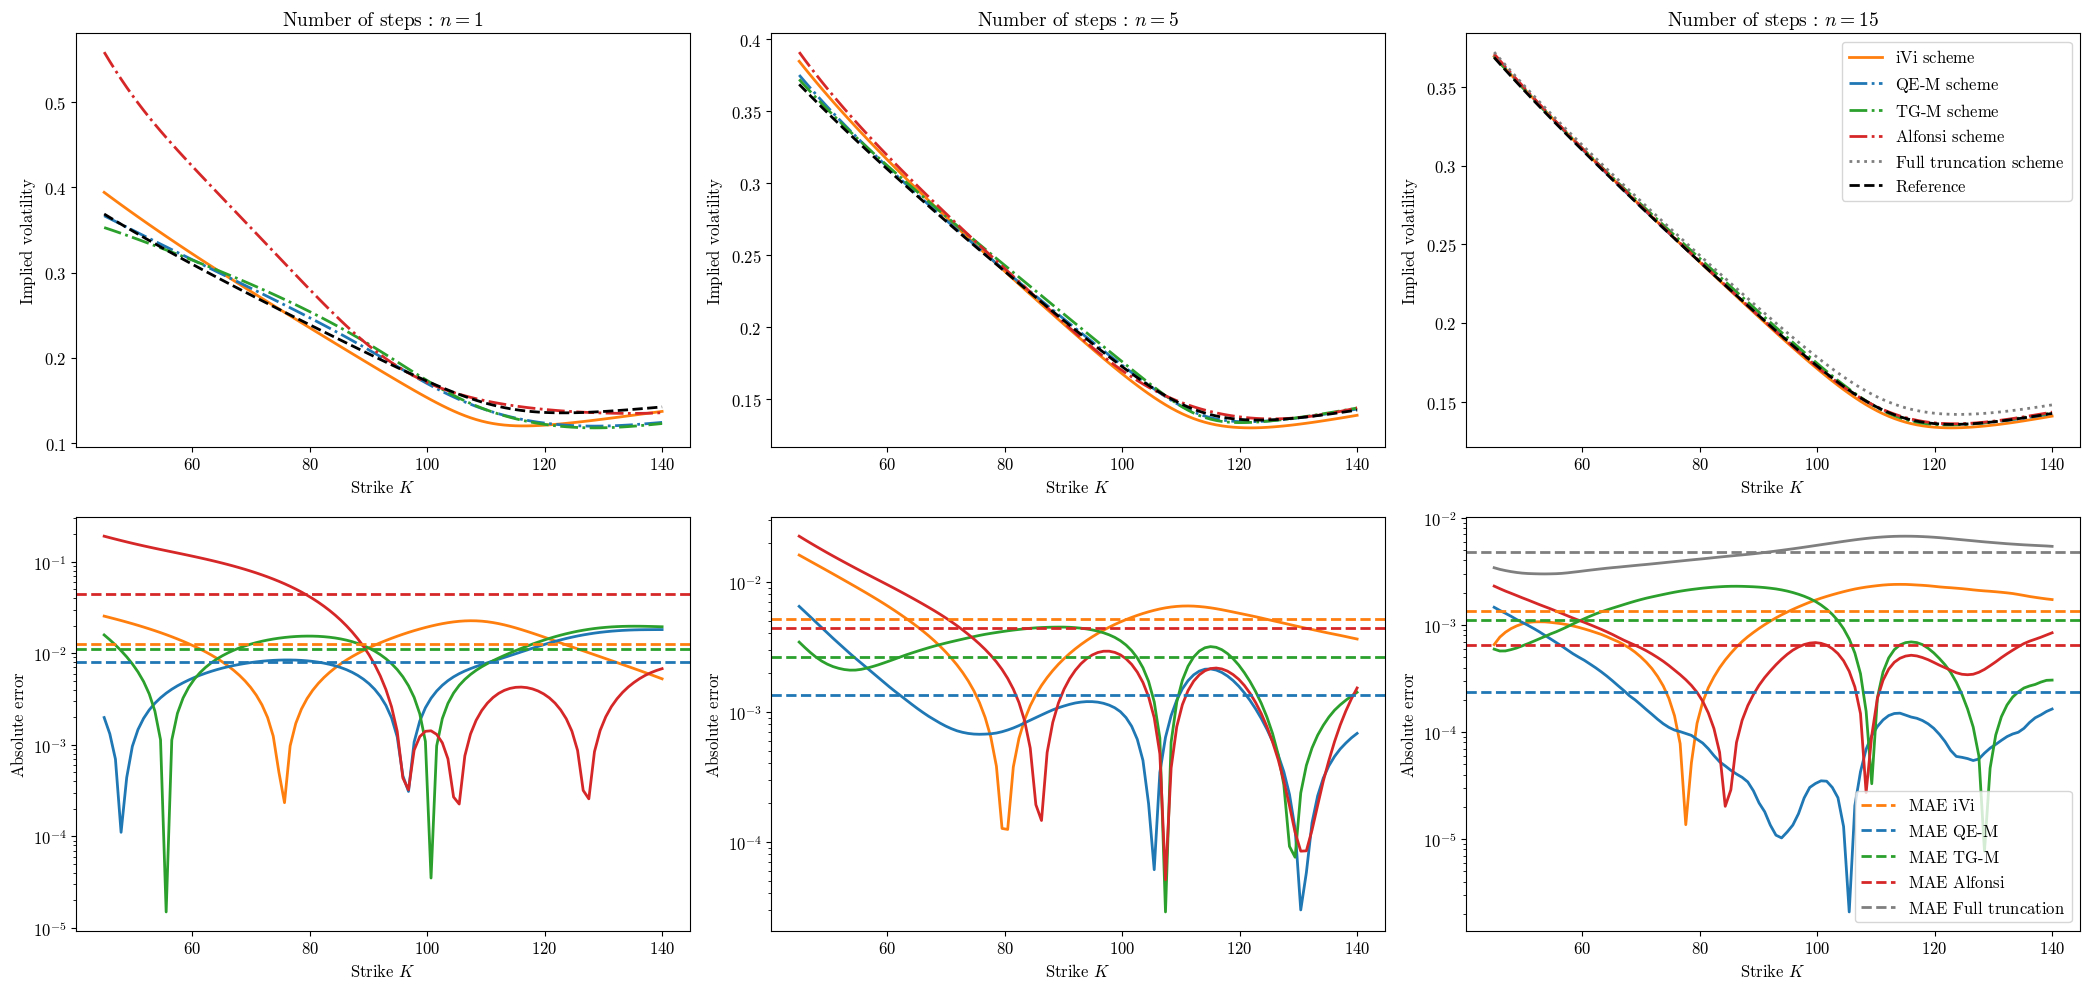

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
ax = ax.flatten()

for i in range(3) : 
    ax[i].plot(K_range, hat_iv[i,:], lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
    ax[i].plot(K_range, QE_iv[i,:], lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
    ax[i].plot(K_range, TG_iv[i,:], lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
    ax[i].plot(K_range, AL_iv[i,:], lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
    if i == 2 : 
        ax[i].plot(K_range, naive_iv, lw=2, color="tab:gray", linestyle=":", label=r"$\text{Full truncation scheme}$")
    ax[i].plot(K_range, true_iv, lw=2, color="black", linestyle="--", label=r"$\text{Reference}$")
    ax[i].set_ylabel(r"$\text{Implied volatility}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Strike }K$", fontsize=12)
    ax[i].set_title(r"$\text{Number of steps : }$" + fr"$n={n_range[i]}$", fontsize=14)
    ax[i].xaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].tick_params(axis='both', labelsize=12)

for i in range(3, 6) :
    ax[i].semilogy(K_range, np.abs(true_iv - hat_iv[i-3,:]), lw=2, color="tab:orange")
    ax[i].semilogy(K_range, np.abs(true_iv - QE_iv[i-3,:]), lw=2, color="tab:blue")
    ax[i].semilogy(K_range, np.abs(true_iv - TG_iv[i-3,:]), lw=2, color="tab:green")
    ax[i].semilogy(K_range, np.abs(true_iv - AL_iv[i-3,:]), lw=2, color="tab:red")
    if i == 5 : 
        ax[i].semilogy(K_range, np.abs(true_iv - naive_iv), lw=2, color="tab:gray")
    ax[i].axhline(hat_MAE[i-3], lw=2, color="tab:orange", linestyle="--", label=r"$\text{MAE iVi}$")
    ax[i].axhline(QE_MAE[i-3], lw=2, color="tab:blue", linestyle="--", label=r"$\text{MAE QE-M}$")
    ax[i].axhline(TG_MAE[i-3], lw=2, color="tab:green", linestyle="--", label=r"$\text{MAE TG-M}$")
    ax[i].axhline(AL_MAE[i-3], lw=2, color="tab:red", linestyle="--", label=r"$\text{MAE Alfonsi}$")
    if i == 5 :
        ax[i].axhline(naive_MAE, lw=2, color="tab:gray", linestyle="--", label=r"$\text{MAE Full truncation}$")
    ax[i].set_ylabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Strike }K$", fontsize=12)
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$"))
    ax[i].xaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].tick_params(axis='both', labelsize=12)

ax[2].legend(loc="upper right", fontsize=12)
ax[5].legend(loc="lower right", fontsize=12)
    
plt.tight_layout()
plt.show()

##### Case 3 

In [37]:
V0, a, b, c, rho, T = 0.04, 0.5 * 0.04, -0.5, 1.0, -0.9, 10
S0 = 100

## for the TG scheme:  
alpha = 5 
psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha)

In [39]:
hat_iv, QE_iv, TG_iv, AL_iv = np.zeros((len(n_range), len(K_range))), np.zeros((len(n_range), len(K_range))), np.zeros((len(n_range), len(K_range))), np.zeros((len(n_range), len(K_range)))
hat_MAE, QE_MAE, TG_MAE, AL_MAE = np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range)), np.zeros(len(n_range))

true_iv = compute_IV_Fourier(K_range, T, S0, V0, a, b, c, rho, 150) 

for i, n in enumerate(tqdm(n_range)) : 
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T, a, b, c, N_values[i][:, :, 0], eta_values[i])
    hat_S = simulate_hat_S(hat_U, hat_Z, S0, rho, N_values[i][:, :, 1])
    mid, _, _ = compute_IV_MC(K_range, T, S0, hat_S[:, -1])
    hat_iv[i,:] = mid
    hat_MAE[i] = np.mean(np.abs(mid - true_iv))

    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i])
    mid, _, _ = compute_IV_MC(K_range, T, S0, S[:, -1])
    QE_iv[i,:] = mid
    QE_MAE[i] = np.mean(np.abs(mid - true_iv))

    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], alpha, f_mu_values, f_sigma_values)
    mid, _, _ = compute_IV_MC(K_range, T, S0, S[:, -1])
    TG_iv[i,:] = mid
    TG_MAE[i] = np.mean(np.abs(mid - true_iv))

    S, _, V = simulate_AL(T, S0, V0, a, b, c, rho, N_values[i][:, :, 1], eta_values[i], bernoulli_values[i]) 
    mid, _, _ = compute_IV_MC(K_range, T, S0, S[:, -1])
    AL_iv[i,:] = mid
    AL_MAE[i] = np.mean(np.abs(mid - true_iv))
    
S, V = simulate_full_truncation(T, S0, V0, a, b, c, rho, N_values[-1])
mid, _, _ = compute_IV_MC(K_range, T, S0, S[:, -1])
naive_iv =  mid
naive_MAE =  np.mean(np.abs(mid - true_iv))

  0%|                                                     | 0/3 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
/opt/anaconda3/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
100%|█████████████████████████████████████████

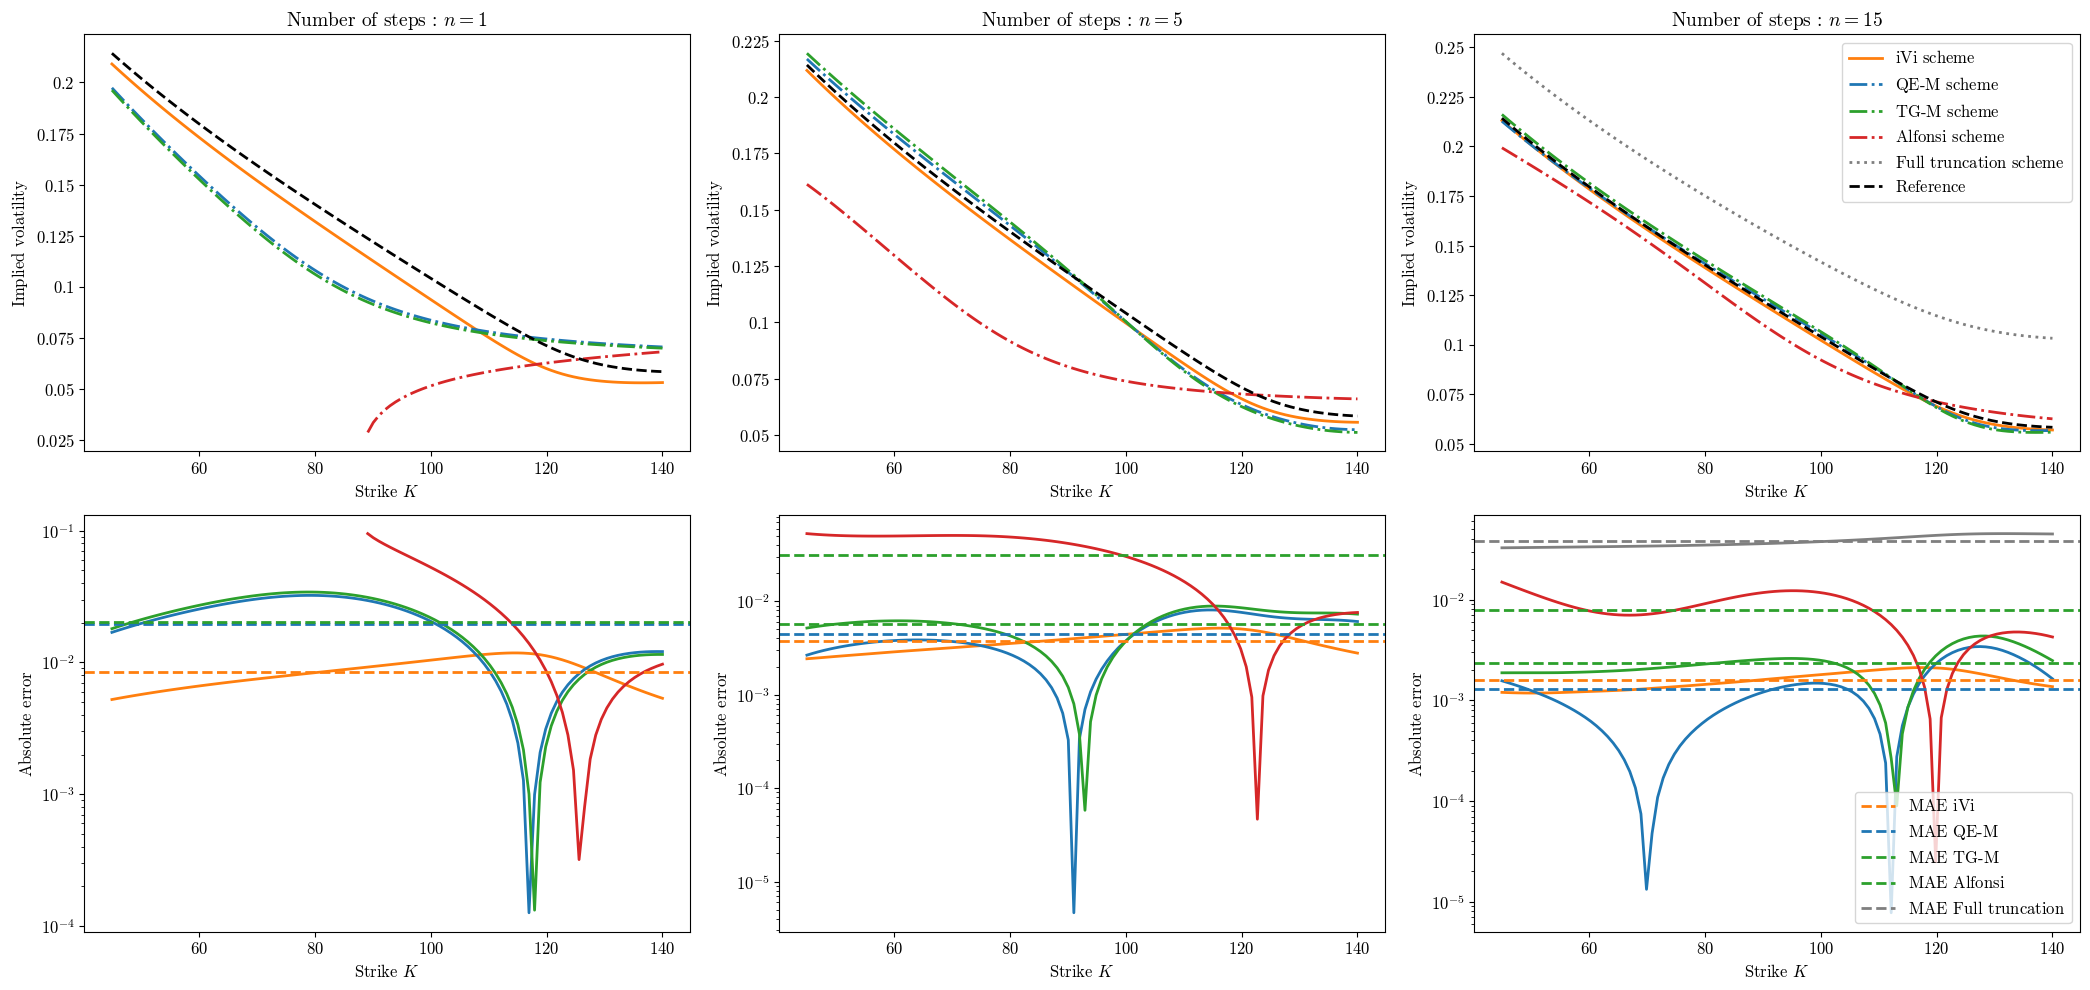

In [49]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
ax = ax.flatten()

for i in range(3) : 
    ax[i].plot(K_range, hat_iv[i,:], lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
    ax[i].plot(K_range, QE_iv[i,:], lw=2, color="tab:blue", linestyle="-.", label=r"$\text{QE-M scheme}$")
    ax[i].plot(K_range, TG_iv[i,:], lw=2, color="tab:green", linestyle="-.", label=r"$\text{TG-M scheme}$")
    ax[i].plot(K_range, AL_iv[i,:], lw=2, color="tab:red", linestyle="-.", label=r"$\text{Alfonsi scheme}$")
    if i == 2 : 
        ax[i].plot(K_range, naive_iv, lw=2, color="tab:gray", linestyle=":", label=r"$\text{Full truncation scheme}$")
    ax[i].plot(K_range, true_iv, lw=2, color="black", linestyle="--", label=r"$\text{Reference}$")
    ax[i].set_ylabel(r"$\text{Implied volatility}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Strike }K$", fontsize=12)
    ax[i].set_title(r"$\text{Number of steps : }$" + fr"$n={n_range[i]}$", fontsize=14)
    ax[i].xaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].tick_params(axis='both', labelsize=12)

for i in range(3, 6) :
    ax[i].semilogy(K_range, np.abs(true_iv - hat_iv[i-3,:]), lw=2, color="tab:orange")
    ax[i].semilogy(K_range, np.abs(true_iv - QE_iv[i-3,:]), lw=2, color="tab:blue")
    ax[i].semilogy(K_range, np.abs(true_iv - TG_iv[i-3,:]), lw=2, color="tab:green")
    ax[i].semilogy(K_range, np.abs(true_iv - AL_iv[i-3,:]), lw=2, color="tab:red")
    if i == 5 : 
        ax[i].semilogy(K_range, np.abs(true_iv - naive_iv), lw=2, color="tab:gray")
    ax[i].axhline(hat_MAE[i-3], lw=2, color="tab:orange", linestyle="--", label=r"$\text{MAE iVi}$")
    ax[i].axhline(QE_MAE[i-3], lw=2, color="tab:blue", linestyle="--", label=r"$\text{MAE QE-M}$")
    ax[i].axhline(TG_MAE[i-3], lw=2, color="tab:green", linestyle="--", label=r"$\text{MAE TG-M}$")
    ax[i].axhline(AL_MAE[i-3], lw=2, color="tab:green", linestyle="--", label=r"$\text{MAE Alfonsi}$")
    if i == 5 :
        ax[i].axhline(naive_MAE, lw=2, color="tab:gray", linestyle="--", label=r"$\text{MAE Full truncation}$")
    ax[i].set_ylabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Strike }K$", fontsize=12)
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$"))
    ax[i].xaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].tick_params(axis='both', labelsize=12)

ax[2].legend(loc="upper right", fontsize=12)
ax[5].legend(loc="lower right", fontsize=12)
    
plt.tight_layout()
plt.show()

#### IV.3. With a single time step 

This subsection provides six slices of the volatility surface computed using the iVi scheme with only a single time step per slice, i.e. $n=1$, highlighting the scheme's efficiency in approximating the entire surface with minimal discretization in high mean-reversion and volatility-of-volatility market regimes. 

In [150]:
S0, V0, a, b, c, rho, T = 100, 0.006, 17.25 * 0.018, -17.25, 2.95, -0.68, 1

In [152]:
T_range = np.array([0.02, 0.1, 0.5, 1, 3, 10])
K_range = np.array([
    np.linspace(90, 105, 100),
    np.linspace(75, 110, 100),
    np.linspace(75, 110, 100),
    np.linspace(60, 135, 100),
    np.linspace(60, 135, 100),
    np.linspace(40, 150, 100),
])
n = 1
M = 2*int(1e6)
N = simulate_antithetic_d(M, n, 2)
eta = np.random.uniform(size=(M, n))

In [154]:
iv = []
true_iv = [] 

for i, T in enumerate(tqdm(T_range)) : 
    if i == 0 : 
        true_iv.append(compute_IV_Fourier(K_range[i], T, S0, V0, a, b, c, rho, 1000, U_max=1000, method="legendre"))
    else : 
        true_iv.append(compute_IV_Fourier(K_range[i], T, S0, V0, a, b, c, rho, 160))
    hat_V, hat_U, hat_Z = simulate_hat_VUZ(V0, T_range[i], a, b, c, N[:, :, 0], eta)
    hat_S = simulate_hat_S(hat_U, hat_Z, S0, rho, N[:, :, 1])
    mid, _, _ = compute_IV_MC(K_range[i], T_range[i], S0, hat_S[:, -1])
    iv.append(mid)

100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.35s/it]


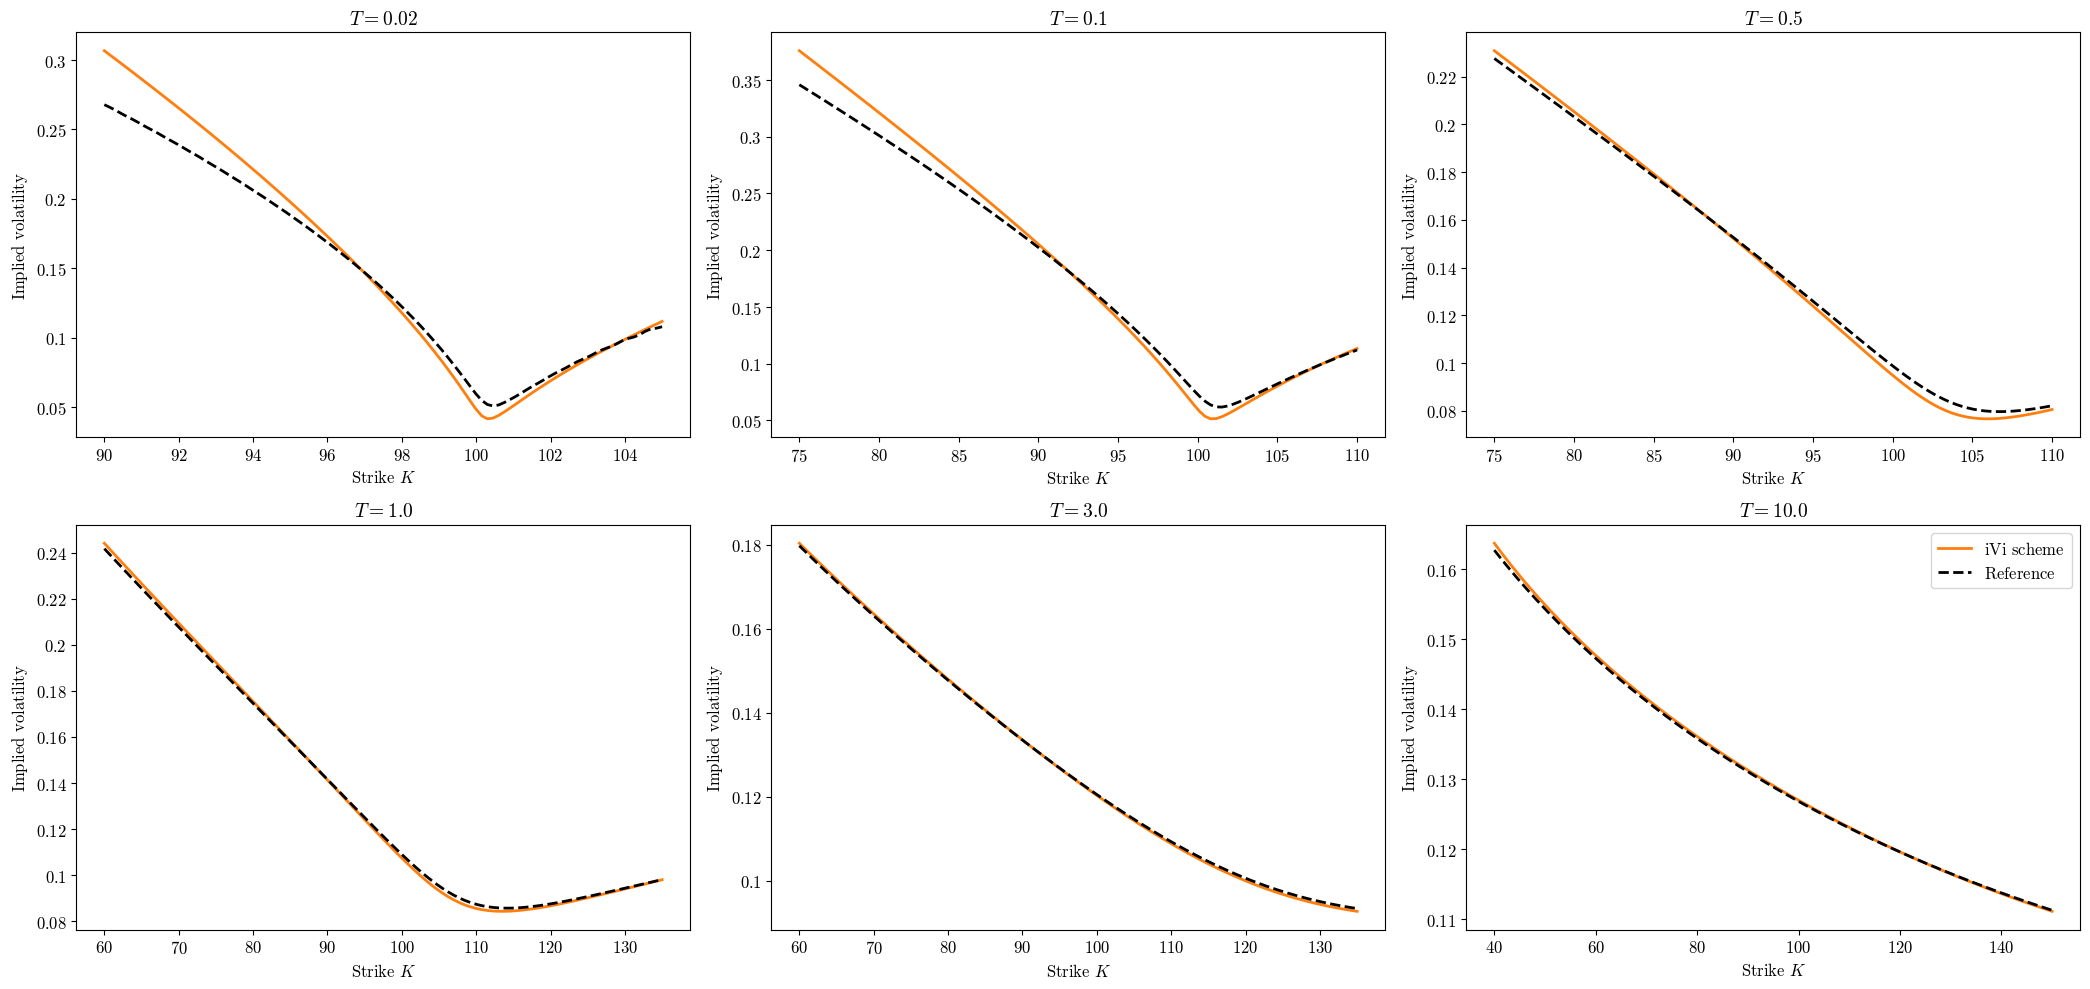

In [155]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
ax = ax.flatten() 

for i in range(6) : 
    ax[i].plot(K_range[i], iv[i], lw=2, color="tab:orange", label=r"$\text{iVi scheme}$")
    ax[i].plot(K_range[i], true_iv[i], linestyle="--", color="black", lw=2, label=r"$\text{Reference}$")
    ax[i].set_ylabel(r"$\text{Implied volatility}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Strike }K$", fontsize=12)
    ax[i].set_title(fr"$T={T_range[i]}$", fontsize=14)
    ax[i].xaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].tick_params(axis='both', labelsize=12)
ax[-1].legend(fontsize=12)

plt.tight_layout()
plt.show()